# Well Count Analysis Notebook: 2 polygons

The purpose of this code is to give percentages of wells classified as having shallow groundwater and their relative proximity to streams.

To run this code, you need the following files in the appropriate folders:
 - Data/Output/Local
   - Master_ADWR_database_noduplicates.shp
   - Master_ADWR_database_water.shp
   - Wells55_GWSI_WLTS_DB_annual_updated.csv
 - Data/Input/Shapefiles
   - flowlines_order#plus.shp
   - WBDHU#.shp

In [76]:
# Packages and paths
# %%
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import geopandas as gp
import scipy.stats as sp
import sys
import seaborn as sns
import math

# Add the path to the Utils folder
utils_path = os.path.abspath(os.path.join('..', 'Utils'))
if utils_path not in sys.path:
    sys.path.append(utils_path)

# Now you can import the functions from CustomFunctions.py
import CustomFunctions as cf

# A fun function unique to this script
# Classify DTW values into categories 
def classify_dtw(dtw):
    if dtw < 2:
        return 'Near Surface (<2m)'
    elif 2 <= dtw < 5:
        return 'Very Shallow (2-5m)'
    elif 5 <= dtw < 10:
        return 'Shallow (5-10m)'
    else:
        return 'Deep (10-61m)'

# Local paths
datapath = '../../Data'
inputpath = '../../Data/Input'
outputpath = '../../Data/Output/Local'
shapepath = inputpath+'/Shapefiles'
figurepath = '../../Figures/Local/'




Providing colors

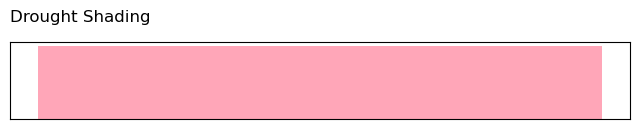

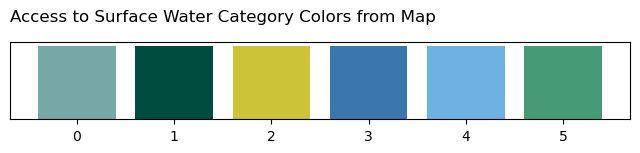

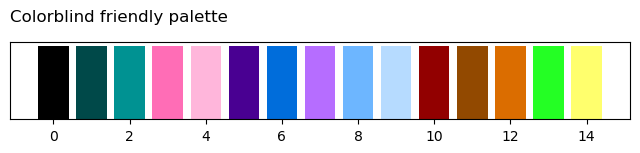

In [2]:
# %% Creating colors
drought_color = '#ffa6b8'

# Color blind palette
# https://jacksonlab.agronomy.wisc.edu/2016/05/23/15-level-colorblind-friendly-palette/
cblind =["#000000","#004949","#009292","#ff6db6","#ffb6db",
 "#490092","#006ddb","#b66dff","#6db6ff","#b6dbff",
 "#920000","#924900","#db6d00","#24ff24","#ffff6d"]

# Colors from map
cap = '#77A8A5' #'#C6652B'
cap_secondary = '#004D40'
# noCAP = '#EDE461' # This is one from the map in the trend paper
noCAP = '#CCC339' # This color but darker for lines
GWdom = '#3B76AF'
mixed = '#6EB2E4'
swdom = '#469B76'
a2sw_colors =[cap,cap_secondary,noCAP,GWdom,mixed,swdom]

# Create a bar plot to visualize colors
palette = [drought_color]
fig, ax = plt.subplots(figsize=(8, 1))
ax.bar(range(len(palette)), height=1, color=palette)
ax.set_title('Drought Shading',loc='left',pad=15)
# Remove y-axis
ax.set_yticks([])
ax.set_xticks([])
plt.show()

palette = a2sw_colors
fig, ax = plt.subplots(figsize=(8, 1))
ax.bar(range(len(palette)), height=1, color=palette)
ax.set_title('Access to Surface Water Category Colors from Map',loc='left',pad=15)
# Remove y-axis
ax.set_yticks([])
plt.show()

palette = cblind
fig, ax = plt.subplots(figsize=(8, 1))
ax.bar(range(len(palette)), height=1, color=palette)
ax.set_title('Colorblind friendly palette',loc='left',pad=15)
# Remove y-axis
ax.set_yticks([])
plt.show()

Read in the main databases.  You only have to do this once.

Master Database might take a while (~5-7 minutes).

In [3]:
# Read in the main Static Database

filename_mdb_nd = 'Master_ADWR_database_noduplicates.shp'
filepath = os.path.join(outputpath, filename_mdb_nd)
print(filepath)

masterdb = gp.read_file(filepath)
pd.options.display.float_format = '{:.2f}'.format
print(masterdb.info())

../../Data/Output/Local\Master_ADWR_database_noduplicates.shp
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 254720 entries, 0 to 254719
Data columns (total 80 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   Combo_ID    254720 non-null  object  
 1   OBJECTID_g  45631 non-null   float64 
 2   SITE_ID     45631 non-null   object  
 3   LOCAL_ID    45631 non-null   object  
 4   REGISTRY_I  233584 non-null  object  
 5   WELL_TYPE   45631 non-null   object  
 6   DD_LAT      45631 non-null   float64 
 7   DD_LONG     45631 non-null   float64 
 8   LAT_NAD27   45631 non-null   object  
 9   LONG_NAD27  45631 non-null   object  
 10  WELL_ALT    45631 non-null   float64 
 11  WATER_USE_  45573 non-null   object  
 12  WELL_DEPTH  214498 non-null  float64 
 13  CASE_DIAM   33772 non-null   float64 
 14  WL_COUNT    45631 non-null   float64 
 15  WL_DTW      34716 non-null   float64 
 16  WL_ELEV     34716 non-null   float64 
 1

In [4]:
# Read in the annual time series database
# This file was created in Well_Timeseries_merge.py

# filename_ts = 'Wells55_GWSI_WLTS_DB_annual_updated.csv'
filename_ts = 'Wells55_GWSI_WLTS_DB_monthly.csv'
filepath = os.path.join(outputpath, filename_ts)
print(filepath)
annual_db = pd.read_csv(filepath, header=1, index_col=0)

#Block to do some formatting
annual_db = annual_db[1:168102]
annual_db.index = annual_db.index.astype('int64')
annual_db2 = annual_db.reset_index(inplace=True)
annual_db2 = annual_db.rename(columns = {'date':'Combo_ID'})
annual_db2.head()

../../Data/Output/Local\Wells55_GWSI_WLTS_DB_monthly.csv


,Combo_ID,1853-12,1856-01,1857-12,1860-01,1864-01,1868-01,1870-01,1871-01,1872-01,...,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12,2024-01,2024-02,2024-03
0,83578,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,84067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,84442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,84455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,84460,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### From here down is where you can rerun the code to generate graphs

In [5]:
# Put your huc number here
huc_num = '4'

In [6]:
# Read in the reach shapefile

# filename_shapeile = '/flowlines_order4plus.shp'
filename_shapeile = '/huc'+huc_num+'flowlines_order3plus.shp'
# filepath = os.path.join(shapepath, filename_shapeile)
filepath = os.path.join(outputpath+filename_shapeile)
shapefile = gp.read_file(filepath)
# shapefile.plot(cmap='viridis')


Take a look at the columns and variables

In [7]:
shapefile

,permanent_,gnis_name,reachcode,streamorde,ID,huc4,huc_name,fcode,hydroseq,geometry
0,67120165,Tse Bonito Wash,15020006000324,3,NaN,1502,Little Colorado,46007,40000800022191.00,"LINESTRING Z (-108.94868 35.67165 0.00000, -10..."
1,67121173,NaN,15020006000758,3,NaN,1502,Little Colorado,46007,40000800026936.00,"LINESTRING Z (-108.91989 35.64257 0.00000, -10..."
2,67120427,NaN,15020006000759,3,NaN,1502,Little Colorado,46007,40000800035112.00,"LINESTRING Z (-108.91691 35.66162 0.00000, -10..."
3,67120223,NaN,15020006003298,3,NaN,1502,Little Colorado,46007,40000800045446.00,"LINESTRING Z (-108.89878 35.67348 0.00000, -10..."
4,67121513,NaN,15020006000758,3,NaN,1502,Little Colorado,46007,40000800023557.00,"LINESTRING Z (-108.90904 35.62311 0.00000, -10..."
...,...,...,...,...,...,...,...,...,...,...
355709,78980520,Willow Creek,14070005000563,3,NaN,1407,Upper Colorado-Dirty Devil,55800,41000100012362.00,"LINESTRING Z (-111.76045 37.65515 0.00000, -11..."
355710,78979158,Upper Valley Creek,14070005000135,5,NaN,1407,Upper Colorado-Dirty Devil,46003,41000100007058.00,"LINESTRING Z (-111.77497 37.72374 0.00000, -11..."
355711,78978248,Birch Creek,14070005000124,4,NaN,1407,Upper Colorado-Dirty Devil,46006,41000100007604.00,"LINESTRING Z (-111.75492 37.77001 0.00000, -11..."
355712,78979176,Upper Valley Creek,14070005000135,5,NaN,1407,Upper Colorado-Dirty Devil,46003,41000100007314.00,"LINESTRING Z (-111.77656 37.72296 0.00000, -11..."


<Axes: >

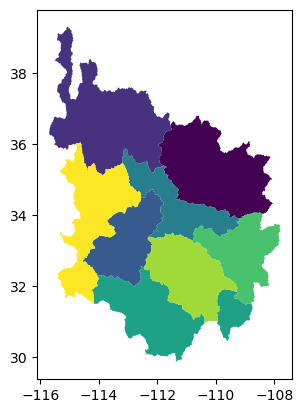

In [9]:
# Read in the watershed boundary shapefile

# filename_shapeile = 'georeg_reproject_fixed.shp'
filename_shapeile = 'WBDHU'+huc_num+'.shp'
filepath = os.path.join(shapepath+"/WBD_15_HU2_Shape/Shape/", filename_shapeile) #This is the path for my laptop
# filepath = os.path.join(shapepath+"/NHD_H_Arizona_State_Shape/Shape/",filename_shapeile)
shapefile_wbd = gp.read_file(filepath)
shapefile_wbd = shapefile_wbd.rename(columns = {'huc'+huc_num:'huc'+huc_num+'_wb',})
shapefile_wbd.plot(cmap='viridis')


Take a look at the columns and variables

In [10]:
shapefile_wbd = shapefile_wbd[['huc'+huc_num+'_wb','geometry']]
shapefile_wbd

,huc4_wb,geometry
0,1502,"POLYGON ((-110.57591 36.79300, -110.57553 36.7..."
1,1501,"POLYGON ((-115.07860 39.30054, -115.07836 39.2..."
2,1507,"POLYGON ((-112.15810 34.71632, -112.15808 34.7..."
3,1506,"POLYGON ((-113.09819 35.86434, -113.09792 35.8..."
4,1508,"MULTIPOLYGON (((-112.53359 32.54199, -112.5333..."
5,1504,"POLYGON ((-108.65524 34.07748, -108.65511 34.0..."
6,1505,"POLYGON ((-111.47785 33.48853, -111.47737 33.4..."
7,1503,"POLYGON ((-114.62325 36.03040, -114.62293 36.0..."


In [11]:
# Define some things about your file

StudyArea = "HUC"+huc_num+"s"
Naming_col = "huc"+huc_num+""
water_designation = swdom 

Merging the databases takes a little time - Approximately 3 minutes

In [12]:
# Merge the shapefile with the master database

shapefile_wbd = shapefile_wbd.to_crs(epsg=26912)
masterdb2 = masterdb.set_crs(epsg=26912)
# For main static database
static_geo = gp.sjoin(masterdb2, shapefile_wbd, how="inner"
                    #   , op='intersects'
                      , predicate='intersects'
                      )

print(str(filename_mdb_nd) + " and " + str(filename_shapeile) + " join complete.")


Master_ADWR_database_noduplicates.shp and WBDHU4.shp join complete.


Check to make sure the merged dataframe looks good

In [13]:
static_geo

,Combo_ID,OBJECTID_g,SITE_ID,LOCAL_ID,REGISTRY_I,WELL_TYPE,DD_LAT,DD_LONG,LAT_NAD27,LONG_NAD27,...,ADDRESS2,CITY,STATE,ZIP,ZIP4,WATER_US_1,SITE_USE,geometry,index_right,huc4_wb
0,060000,NaN,NaN,NaN,060000,NaN,NaN,NaN,NaN,NaN,...,850 W. ELLIOT RD. STE 106,TEMPE,AZ,85284,NaN,DEWATERING,WATER PRODUCTION,POINT (423912.100 3646244.000),6,1505
3,083226,NaN,NaN,NaN,083226,NaN,NaN,NaN,NaN,NaN,...,NaN,WILLCOX,AZ,85643,NaN,DOMESTIC,WATER PRODUCTION,POINT (612466.500 3573775.000),6,1505
4,083578,NaN,NaN,NaN,083578,NaN,NaN,NaN,NaN,NaN,...,NaN,TUMACACORI,AZ,85640,NaN,DOMESTIC,WATER PRODUCTION,POINT (496526.600 3495617.000),6,1505
5,083716,NaN,NaN,NaN,083716,NaN,NaN,NaN,NaN,NaN,...,NaN,SIERRA VISTA,AZ,85635,NaN,DOMESTIC,WATER PRODUCTION,POINT (571088.500 3476698.000),6,1505
6,084067,NaN,NaN,NaN,084067,NaN,NaN,NaN,NaN,NaN,...,NaN,TUCSON,AZ,85732,NaN,IRRIGATION,WATER PRODUCTION,POINT (517507.200 3568961.000),6,1505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253351,929784,NaN,NaN,NaN,929784,NaN,NaN,NaN,NaN,NaN,...,NaN,PEARCE,AZ,85625,NaN,DOMESTIC,NaN,POINT (629902.100 3528847.000),4,1508
253802,930246,NaN,NaN,NaN,930246,NaN,NaN,NaN,NaN,NaN,...,NaN,PHOENIX,AZ,85007,NaN,MONITORING,CAPPED,POINT (637046.400 3469353.000),4,1508
253805,930249,NaN,NaN,NaN,930249,NaN,NaN,NaN,NaN,NaN,...,NaN,PHOENIX,AZ,85007,NaN,MONITORING,NaN,POINT (637850.400 3469364.000),4,1508
253806,930250,NaN,NaN,NaN,930250,NaN,NaN,NaN,NaN,NaN,...,NaN,PHOENIX,AZ,85007,NaN,MONITORING,NaN,POINT (637651.400 3469159.000),4,1508


In [14]:
static_geo = static_geo.drop(columns='index_right')
static_geo.columns

Index(['Combo_ID', 'OBJECTID_g', 'SITE_ID', 'LOCAL_ID', 'REGISTRY_I',
       'WELL_TYPE', 'DD_LAT', 'DD_LONG', 'LAT_NAD27', 'LONG_NAD27', 'WELL_ALT',
       'WATER_USE_', 'WELL_DEPTH', 'CASE_DIAM', 'WL_COUNT', 'WL_DTW',
       'WL_ELEV', 'SOURCE', 'IDXBK', 'DRILL_DATE', 'LASTWLDATE', 'QUASI_IDX_',
       'GOES_ENABL', 'TRANSDUCER', 'IDXBK2', 'FREQUENCY', 'Original_D',
       'OBJECTID_w', 'PROGRAM', 'OWNER_NAME', 'RGR_PUMP_D', 'WELLTYPE',
       'WELL_TYPE_', 'DLIC_NUM', 'APPROVED', 'INSTALLED', 'WATER_LEVE',
       'CASING_DEP', 'CASING_DIA', 'CASING_TYP', 'PUMP_TYPE', 'PUMP_POWER',
       'PUMPRATE', 'TESTEDRATE', 'DRAW_DOWN', 'COMPLETION', 'DRILL_LOG',
       'WELL_CANCE', 'CADASTRAL', 'COUNTY', 'WATERSHED', 'BASIN_NAME',
       'SUBBASIN_N', 'AMA', 'QUAD_CODE', 'WHOLE_TOWN', 'HALF_TOWNS',
       'NORTHSOUTH', 'WHOLE_RANG', 'HALF_RANGE', 'EASTWEST', 'SECTION',
       'QUARTER_16', 'QACRE160DI', 'QUARTER_40', 'QACRE40DIR', 'QUARTER_10',
       'QACRE10DIR', 'UTM_X_METE', 'UTM_Y_METE'

In [15]:
# Pull out the columns you need
# Use this for subbasins:
# reg_list = static_geo[['Combo_ID', Naming_col+'_right','WELL_DEPTH','WELL_TYPE_']]

# Use this or cities:
reg_list = static_geo[['Combo_ID', Naming_col+'_wb','WELL_DEPTH','WELL_TYPE_'
                    #    ,'reachcode','fcode','hydroseq'
                       ]]
# reg_list

# %% Converting Combo_ID to int
reg_list['Combo_ID'] = reg_list['Combo_ID'].astype(np.int64, errors = 'raise')

C:\Users\det19\AppData\Local\Temp\ipykernel_8152\1340034797.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_list['Combo_ID'] = reg_list['Combo_ID'].astype(np.int64, errors = 'raise')


In [16]:
# Merging the Timeseries and the shapefile static database
combo = annual_db2.merge(reg_list, how="inner")
combo.info()

# %% set index to Combo_ID
combo.set_index('Combo_ID', inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167712 entries, 0 to 167711
Columns: 1417 entries, Combo_ID to WELL_TYPE_
dtypes: float64(1414), int64(1), object(2)
memory usage: 1.8+ GB


In [17]:
combo

,1853-12,1856-01,1857-12,1860-01,1864-01,1868-01,1870-01,1871-01,1872-01,1873-01,...,2023-09,2023-10,2023-11,2023-12,2024-01,2024-02,2024-03,huc4_wb,WELL_DEPTH,WELL_TYPE_
Combo_ID,,,,,,,,,,,,,,,,,,,,,
83578,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1505,101.00,NON-EXEMPT
84067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1505,150.00,NON-EXEMPT
84442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1505,1601.00,NON-EXEMPT
84455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1505,346.00,EXEMPT
84460,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1505,300.00,EXEMPT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364528113101401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1501,20.00,NaN
364550112401201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1501,400.00,NaN
364614114054601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1501,430.00,NaN


Here we only want shallow wells (anything less than 200ft) and to remove wells with default 0 drilling depth values

In [18]:
# Filter by drilling depth
test = combo.copy()
# test["WELL_DEPTH"] = test["WELL_DEPTH"].astype("float64")  # Converts column to integer (handles NaNs)
test = test[(test['WELL_DEPTH']<=200)&(test['WELL_DEPTH']>0)]
# test['WELL_DEPTH'].unique()
test


,1853-12,1856-01,1857-12,1860-01,1864-01,1868-01,1870-01,1871-01,1872-01,1873-01,...,2023-09,2023-10,2023-11,2023-12,2024-01,2024-02,2024-03,huc4_wb,WELL_DEPTH,WELL_TYPE_
Combo_ID,,,,,,,,,,,,,,,,,,,,,
83578,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1505,101.00,NON-EXEMPT
84067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1505,150.00,NON-EXEMPT
84614,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1504,80.00,NON-EXEMPT
84630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1503,130.00,NON-EXEMPT
84633,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1503,97.00,NON-EXEMPT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363822111515101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1501,50.00,NaN
364327113040601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1501,25.00,NaN
364328113040801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1501,23.00,NaN


This portion of the code makes sure a well isn't being counted multiple times

In [19]:
combo_copy = test.copy()
df = combo_copy.reset_index()  # Moves well_ID from index to a column (if needed)
df = df.drop_duplicates(subset=["Combo_ID", Naming_col+"_wb"])
df = df.set_index("Combo_ID")
df


,1853-12,1856-01,1857-12,1860-01,1864-01,1868-01,1870-01,1871-01,1872-01,1873-01,...,2023-09,2023-10,2023-11,2023-12,2024-01,2024-02,2024-03,huc4_wb,WELL_DEPTH,WELL_TYPE_
Combo_ID,,,,,,,,,,,,,,,,,,,,,
83578,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1505,101.00,NON-EXEMPT
84067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1505,150.00,NON-EXEMPT
84614,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1504,80.00,NON-EXEMPT
84630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1503,130.00,NON-EXEMPT
84633,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1503,97.00,NON-EXEMPT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363822111515101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1501,50.00,NaN
364327113040601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1501,25.00,NaN
364328113040801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1501,23.00,NaN


In [20]:
# Grouping the appropriate column
# combo_copy = combo.copy()
combo_copy = df.copy()
combo_copy = combo_copy.drop(['WELL_DEPTH','WELL_TYPE_'
                            #   ,'nan','reachcode','fcode','hydroseq'
                              ],axis=1)


In [21]:
combo_copy

,1853-12,1856-01,1857-12,1860-01,1864-01,1868-01,1870-01,1871-01,1872-01,1873-01,...,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12,2024-01,2024-02,2024-03,huc4_wb
Combo_ID,,,,,,,,,,,,,,,,,,,,,
83578,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1505
84067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1505
84614,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1504
84630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1503
84633,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363822111515101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1501
364327113040601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1501
364328113040801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1501


This bit of code will remove any wells with anomalous readings (e.g. anything greater than 500ft)

In [22]:
df = combo_copy.copy()

# Example: Your dataframe (df) has columns as YYYY-MM and 'Combo_ID' + 'huc12'
# Step 1: Filter columns for readings after 1980
date_cols = [col for col in df.columns if col not in ['Combo_ID', Naming_col+"_wb"] and col >= '1980-01']

# Step 2: Find wells with any reading > 500 ft in these columns
mask = (df[date_cols] > 200).any(axis=1)

# Step 3: Drop wells that meet this condition
df_filtered = df[~mask]

# Now df_filtered contains only wells that never exceeded 500 ft after 1980
df_filtered


,1853-12,1856-01,1857-12,1860-01,1864-01,1868-01,1870-01,1871-01,1872-01,1873-01,...,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12,2024-01,2024-02,2024-03,huc4_wb
Combo_ID,,,,,,,,,,,,,,,,,,,,,
83578,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1505
84067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1505
84614,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1504
84630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1503
84633,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363822111515101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1501
364327113040601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1501
364328113040801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1501


In [23]:
df = df_filtered.copy()
df = df.reset_index()

# Convert column names (dates) to integers, excluding non-date columns like 'Well ID' and 'HUC'
# date_cols = [col for col in df.columns if col not in ['Combo_ID', Naming_col+"_wb"]]
date_cols = [col for col in df.columns if col not in ['Combo_ID', Naming_col+"_wb"] and col >= '1980-01']  # Keep only years >= 1980

# Create a new DataFrame with only relevant columns
df = df[['Combo_ID', Naming_col+"_wb"] + date_cols]
df


,Combo_ID,huc4_wb,1980-01,1980-02,1980-03,1980-04,1980-05,1980-06,1980-07,1980-08,...,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12,2024-01,2024-02,2024-03
0,83578,1505,NaN,NaN,NaN,12.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,84067,1505,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,84614,1504,NaN,NaN,NaN,NaN,NaN,NaN,12.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,84630,1503,NaN,NaN,NaN,NaN,NaN,18.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,84633,1503,NaN,NaN,NaN,NaN,NaN,18.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65781,363822111515101,1501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65782,364327113040601,1501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65783,364328113040801,1501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65784,364422112461201,1501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
df = df.drop(columns='nan')

KeyError: "['nan'] not found in axis"

In [25]:
df

,Combo_ID,huc4_wb,1980-01,1980-02,1980-03,1980-04,1980-05,1980-06,1980-07,1980-08,...,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12,2024-01,2024-02,2024-03
0,83578,1505,NaN,NaN,NaN,12.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,84067,1505,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,84614,1504,NaN,NaN,NaN,NaN,NaN,NaN,12.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,84630,1503,NaN,NaN,NaN,NaN,NaN,18.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,84633,1503,NaN,NaN,NaN,NaN,NaN,18.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65781,363822111515101,1501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65782,364327113040601,1501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65783,364328113040801,1501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65784,364422112461201,1501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
df['1980-01'].iloc[0]

nan

In [ ]:
# df = df_filtered.copy()

# Convert columns (dates) to rows, keeping 'HUC' and 'Well ID' as identifiers
df_melted = df.melt(id_vars=['Combo_ID', Naming_col+"_wb"], var_name='Date', value_name='DTW')

# Convert 'Date' column to datetime format
df_melted['Date'] = pd.to_datetime(df_melted['Date'])
df_melted = df_melted.dropna(subset=['DTW'])

# Convert DTW from feet to meters
df_melted['DTW_meters'] = df_melted['DTW'] * 0.3048  # Apply conversion

df_melted['DTW_Category'] = df_melted['DTW_meters'].apply(classify_dtw)

# Extract decade for grouping (or use whole period if preferred)
df_melted['Decade'] = (df_melted['Date'].dt.year // 10) * 10  # Rounds to nearest decade

# Count the number of wells in each category per time period
summary_df = df_melted.groupby(['Decade', 'DTW_Category'])['Combo_ID'].nunique().reset_index()

# summary_df = df_melted.groupby(['DTW_Category'])['Combo_ID'].nunique().reset_index()

# Rename for clarity
summary_df.rename(columns={'Combo_ID': 'Well Count'}, inplace=True)

summary_df

,Decade,DTW_Category,Well Count
0,1980,Deep (10-61m),6509
1,1980,Near Surface (<2m),1740
2,1980,Shallow (5-10m),2665
3,1980,Very Shallow (2-5m),1944
4,1990,Deep (10-61m),10044
5,1990,Near Surface (<2m),2187
6,1990,Shallow (5-10m),3015
7,1990,Very Shallow (2-5m),2490
8,2000,Deep (10-61m),7628
9,2000,Near Surface (<2m),427


In [28]:
df_melted

,Combo_ID,huc4_wb,Date,DTW,DTW_meters,DTW_Category,Decade
1,84067,1505,1980-01-01,0.00,0.00,Near Surface (<2m),1980
9,84810,1502,1980-01-01,28.00,8.53,Shallow (5-10m),1980
11,84824,1507,1980-01-01,45.00,13.72,Deep (10-61m),1980
12,84828,1506,1980-01-01,18.00,5.49,Shallow (5-10m),1980
16,84956,1506,1980-01-01,24.00,7.32,Shallow (5-10m),1980
...,...,...,...,...,...,...,...
34917290,646927,1501,2024-03-01,2.80,0.85,Near Surface (<2m),2020
34928885,321436110451801,1505,2024-03-01,16.80,5.12,Shallow (5-10m),2020
34932165,351201112103801,1501,2024-03-01,4.00,1.22,Near Surface (<2m),2020
34932166,351202112103001,1501,2024-03-01,5.60,1.71,Near Surface (<2m),2020


In [46]:
df_melted = df_melted.sort_values(by=[Naming_col+"_wb", "Date"])

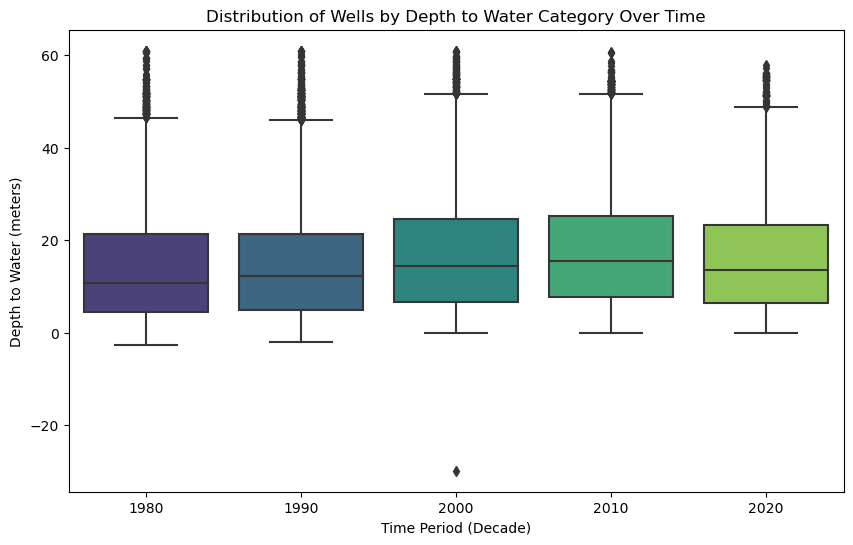

In [47]:
# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_melted, 
            x='Decade',
            y='DTW_meters', 
            # hue='Decade', 
            palette='viridis'
            )

plt.title('Distribution of Wells by Depth to Water Category Over Time')
plt.xlabel('Time Period (Decade)')
plt.ylabel('Depth to Water (meters)')
# plt.legend(title='DTW Category')
plt.xticks(rotation=0)
plt.show()


<Axes: xlabel='Decade', ylabel='DTW_meters'>

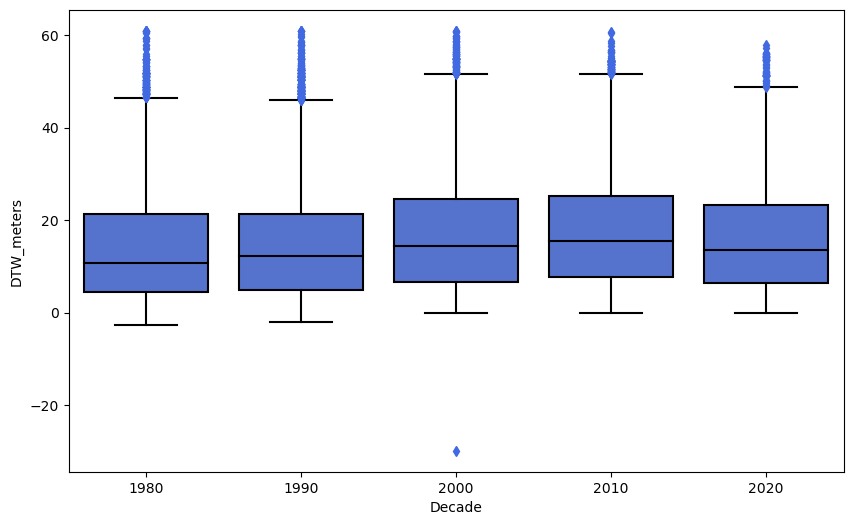

In [43]:
# Define a single color for the boxes
box_color = "royalblue"  # Change to any color you like

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_melted, 
    x='Decade',
    y='DTW_meters',
    color=box_color,  # This sets all boxes to the same color
    boxprops=dict(edgecolor="black"),  # Box edges
    medianprops=dict(color="black"),  # Median line
    whiskerprops=dict(color="black"),  # Whiskers
    capprops=dict(color="black"),  # Caps
    flierprops=dict(markerfacecolor=box_color, markeredgecolor=box_color)  # Outliers
)

In [33]:
df_melted

,Combo_ID,huc4_wb,Date,DTW,DTW_meters,DTW_Category,Decade
1,84067,1505,1980-01-01,0.00,0.00,Near Surface (<2m),1980
9,84810,1502,1980-01-01,28.00,8.53,Shallow (5-10m),1980
11,84824,1507,1980-01-01,45.00,13.72,Deep (10-61m),1980
12,84828,1506,1980-01-01,18.00,5.49,Shallow (5-10m),1980
16,84956,1506,1980-01-01,24.00,7.32,Shallow (5-10m),1980
...,...,...,...,...,...,...,...
34917290,646927,1501,2024-03-01,2.80,0.85,Near Surface (<2m),2020
34928885,321436110451801,1505,2024-03-01,16.80,5.12,Shallow (5-10m),2020
34932165,351201112103801,1501,2024-03-01,4.00,1.22,Near Surface (<2m),2020
34932166,351202112103001,1501,2024-03-01,5.60,1.71,Near Surface (<2m),2020


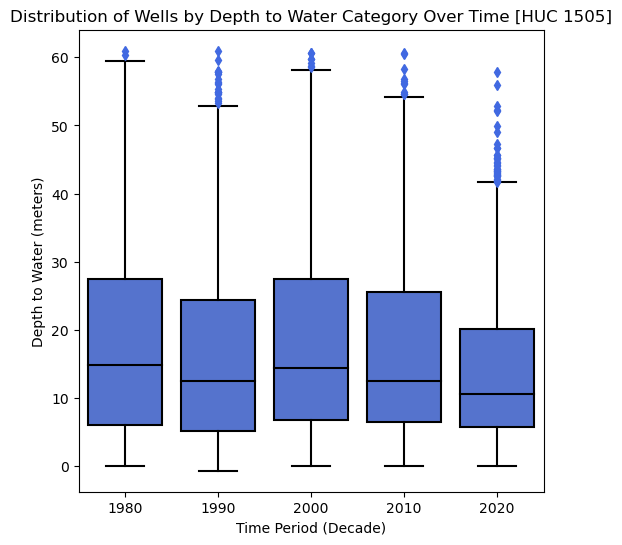

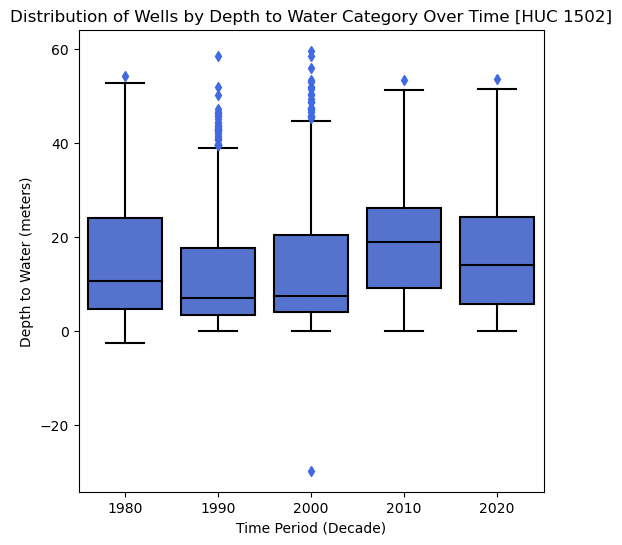

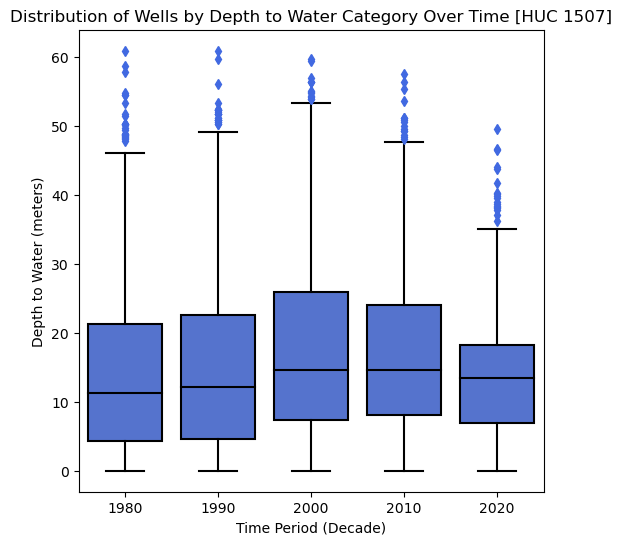

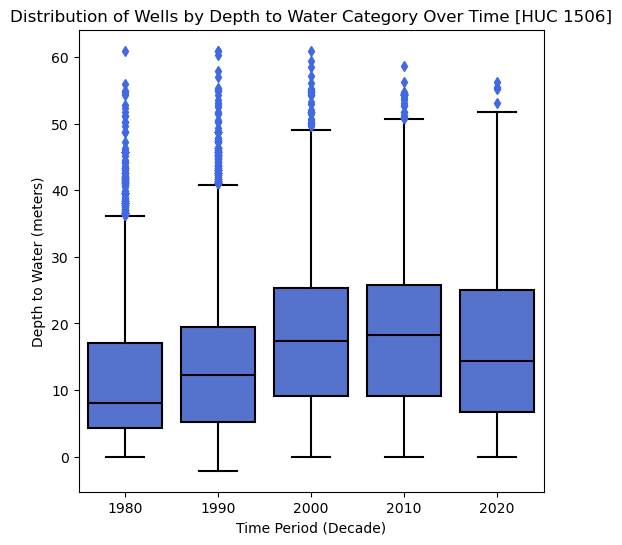

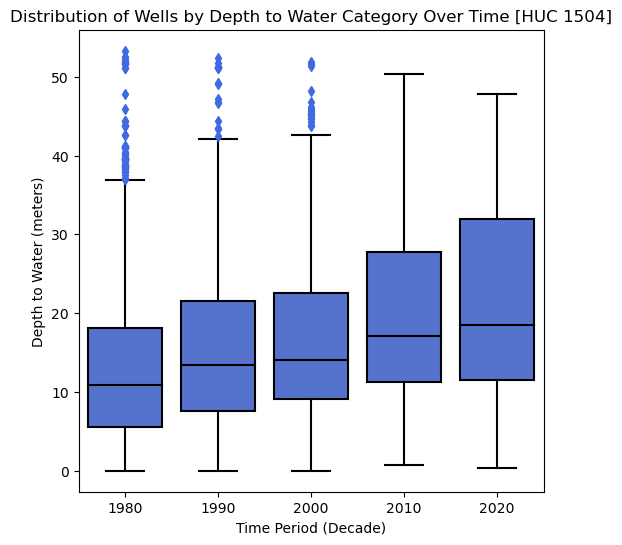

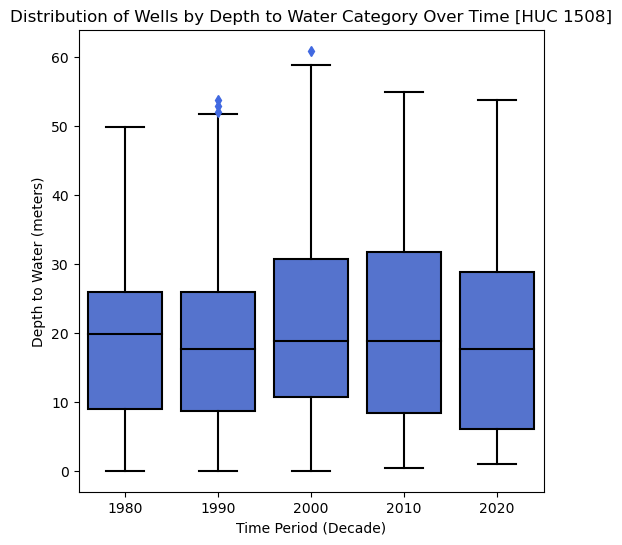

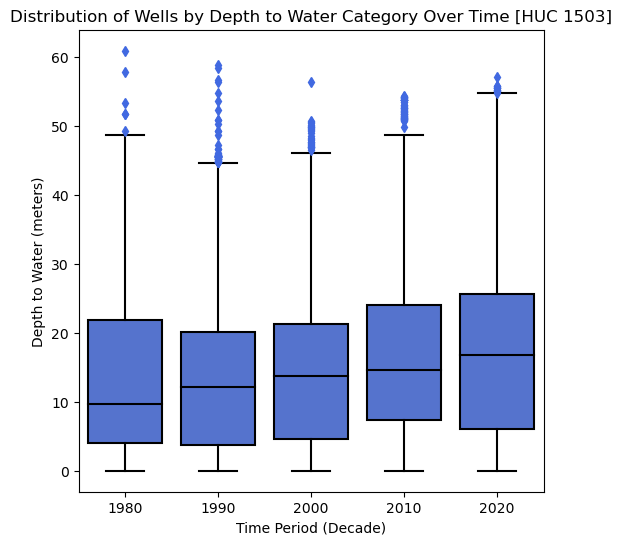

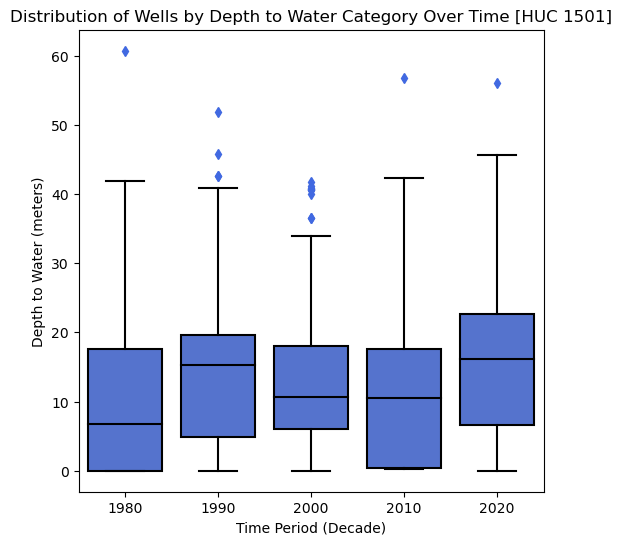

In [ ]:
listofhucs = df_melted[Naming_col+"_wb"].unique().tolist()

for bitch in listofhucs:
    # Subset data for the huc
    subset = df_melted[df_melted[Naming_col+"_wb"] == bitch]
    
    # Define a single color for the boxes
    box_color = "royalblue"  # Change to any color you like

    # Plot
    plt.figure(figsize=(6, 6))
    sns.boxplot(
        data=subset, 
        x='Decade',
        y='DTW_meters',
        color=box_color,  # This sets all boxes to the same color
        boxprops=dict(edgecolor="black"),  # Box edges
        medianprops=dict(color="black"),  # Median line
        whiskerprops=dict(color="black"),  # Whiskers
        capprops=dict(color="black"),  # Caps
        flierprops=dict(markerfacecolor=box_color, markeredgecolor=box_color)  # Outliers
    )

    plt.title('Distribution of Wells by Depth to Water Category Over Time [HUC '+bitch+']')
    plt.xlabel('Time Period (Decade)')
    plt.ylabel('Depth to Water (meters)')
    plt.xticks(rotation=0)
    plt.show()


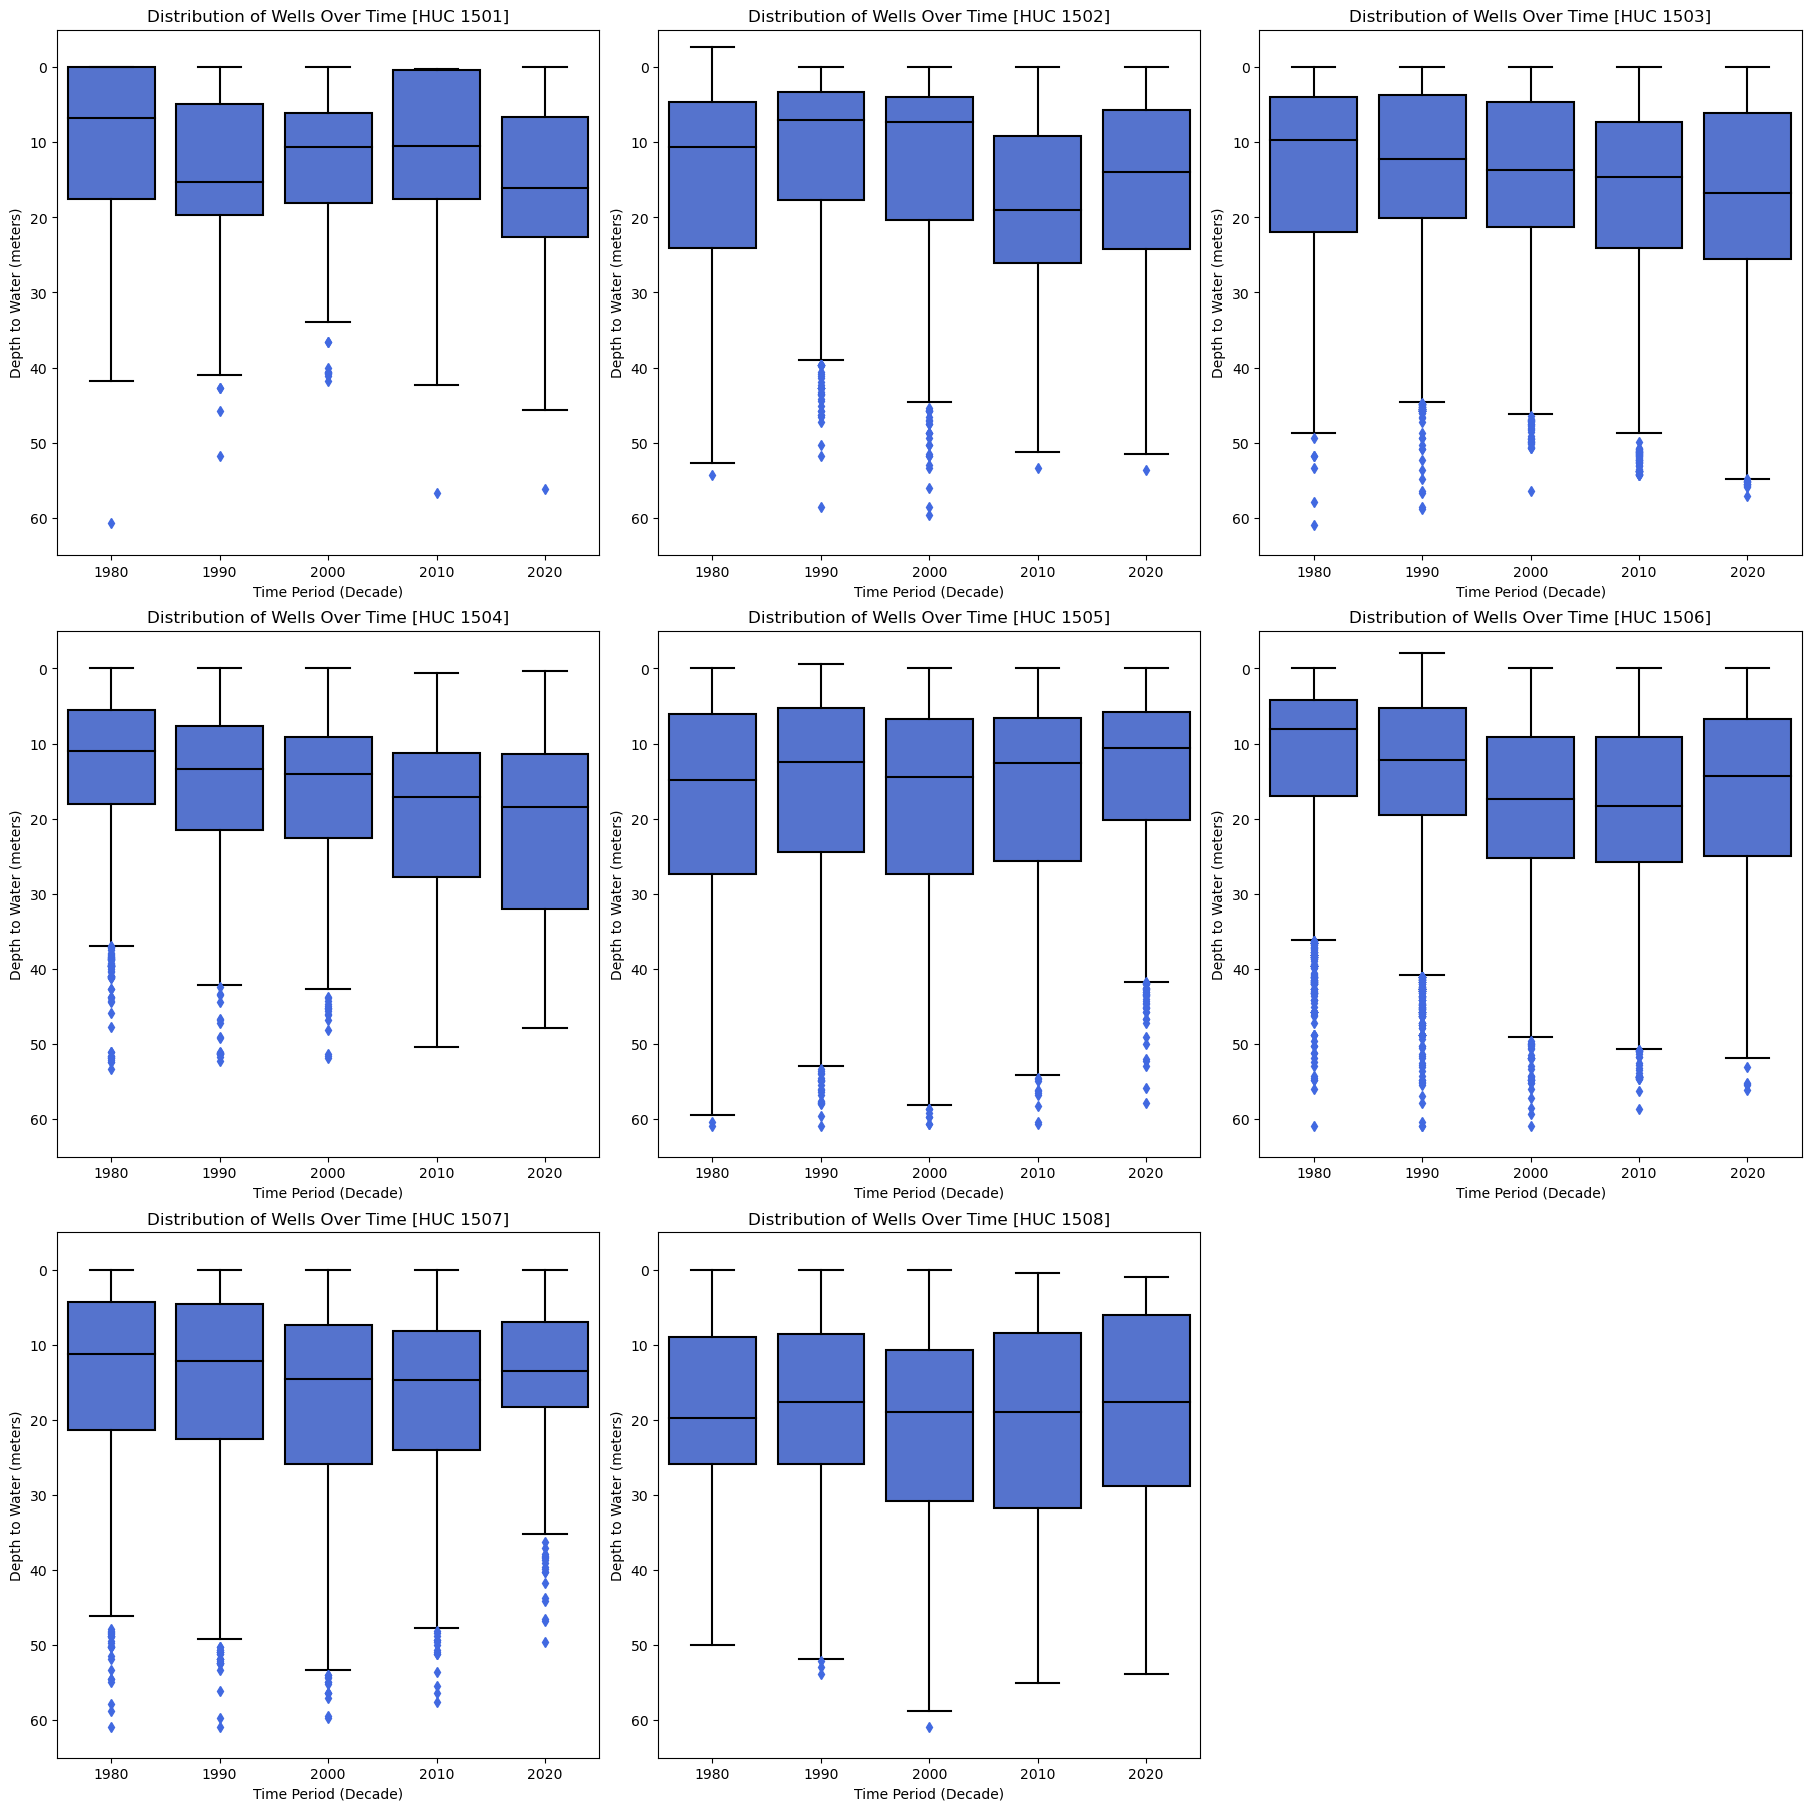

In [51]:
listofhucs = df_melted[Naming_col+"_wb"].unique().tolist()
num_hucs = len(listofhucs)

# Determine grid size
cols = math.ceil(math.sqrt(num_hucs))  # Try to make a roughly square grid
rows = math.ceil(num_hucs / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 6), constrained_layout=True)

# Flatten axes if there's more than one row
if rows > 1 or cols > 1:
    axes = axes.flatten()
else:
    axes = [axes]  # Ensure it's iterable

# Define a single color for the boxes
box_color = "royalblue"

for i, bitch in enumerate(listofhucs):
    subset = df_melted[df_melted[Naming_col+"_wb"] == bitch]

    sns.boxplot(
        data=subset, 
        x='Decade',
        y='DTW_meters',
        color=box_color,
        ax=axes[i],  # Assign each plot to a subplot
        boxprops=dict(edgecolor="black"),
        medianprops=dict(color="black"),
        whiskerprops=dict(color="black"),
        capprops=dict(color="black"),
        flierprops=dict(markerfacecolor=box_color, markeredgecolor=box_color)
    )

    axes[i].set_title(f'Distribution of Wells Over Time [HUC {bitch}]')
    axes[i].set_xlabel('Time Period (Decade)')
    axes[i].set_ylabel('Depth to Water (meters)')
    axes[i].tick_params(axis='x', rotation=0)
    axes[i].set_ylim(65, -5)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()


These box plots aren't particularly informative but thought they were interesting

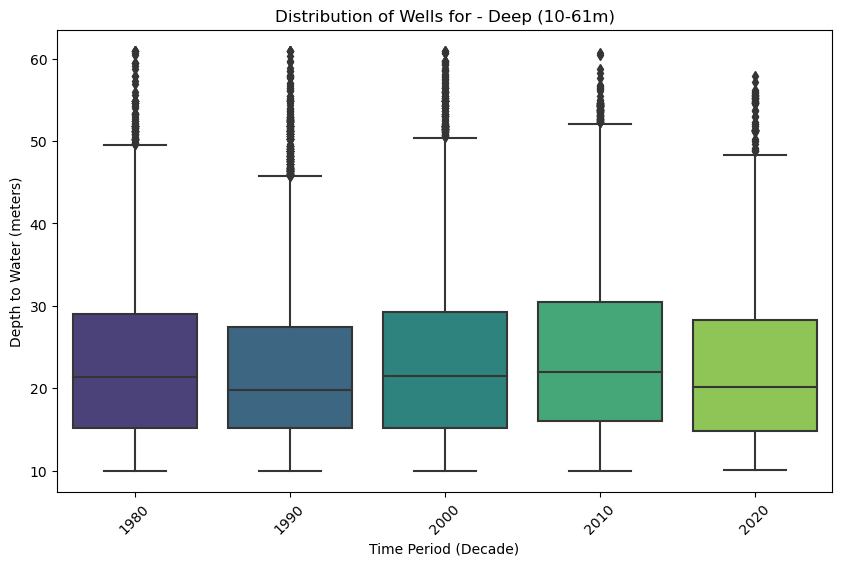

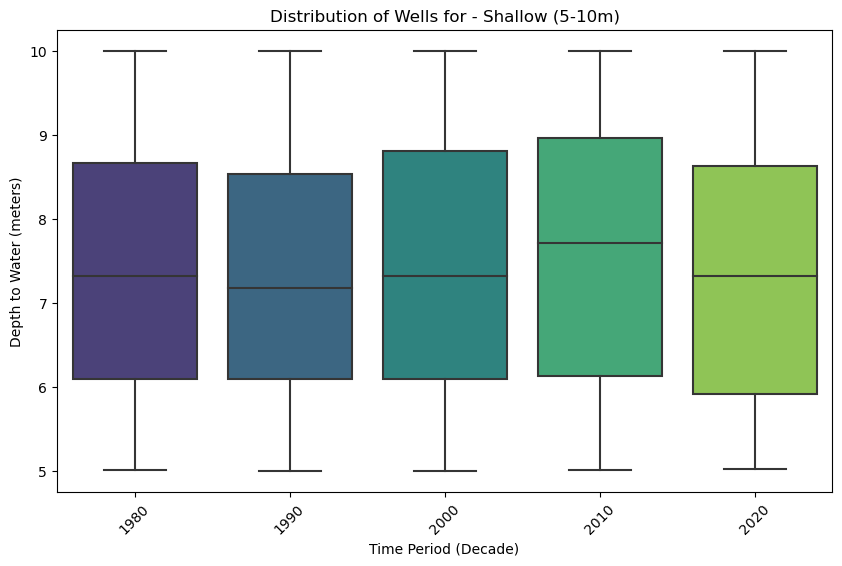

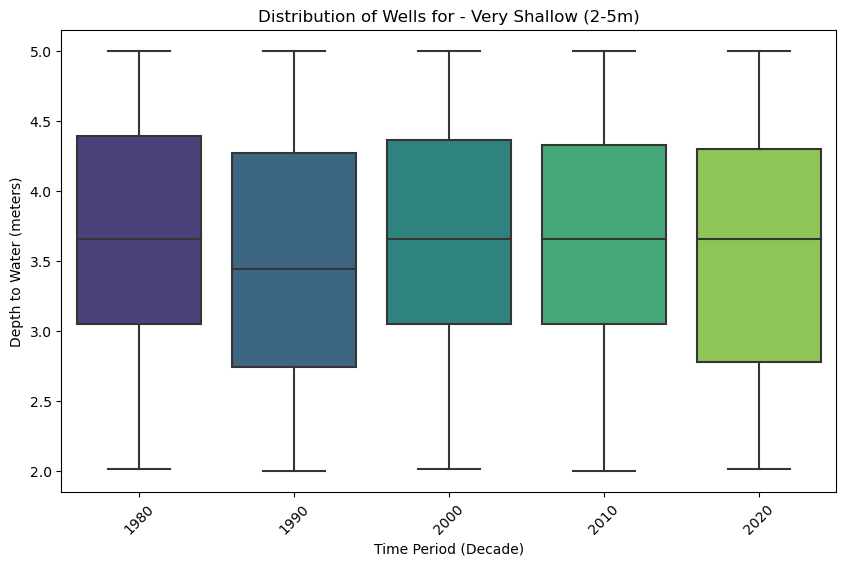

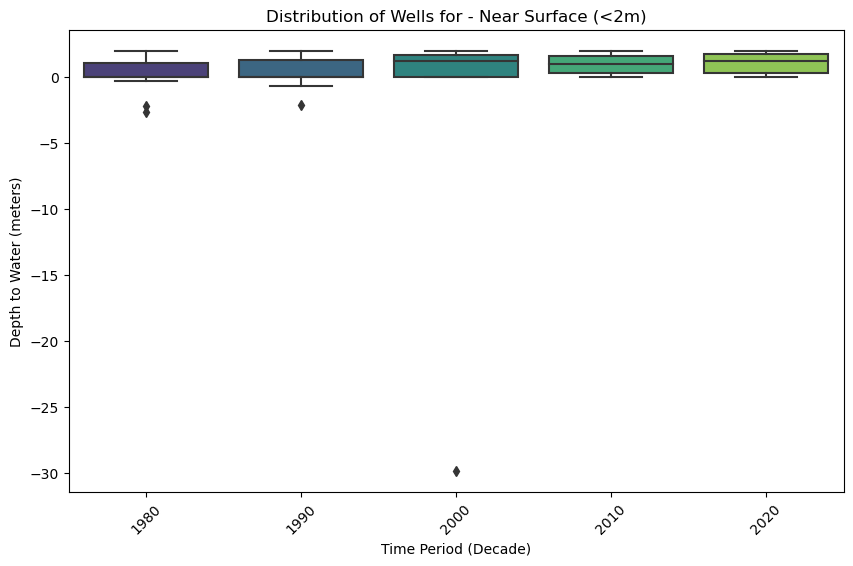

In [53]:
# Get unique DTW categories
dtw_categories = df_melted['DTW_Category'].unique()

# Loop through each DTW category and create a box plot
for category in dtw_categories:
    plt.figure(figsize=(10, 6))
    
    # Subset data for the current category
    subset = df_melted[df_melted['DTW_Category'] == category]

    # Create the box plot
    sns.boxplot(data=subset, x='Decade', y='DTW_meters', palette='viridis')

    # Titles and labels
    plt.title(f'Distribution of Wells for - {category}')
    plt.xlabel('Time Period (Decade)')
    plt.ylabel('Depth to Water (meters)')
    plt.xticks(rotation=45)

    # Show the plot
    plt.show()

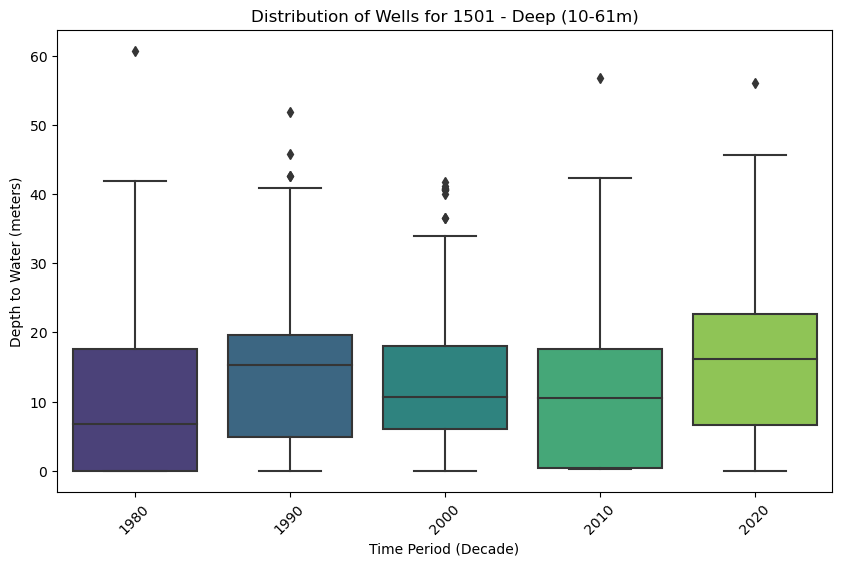

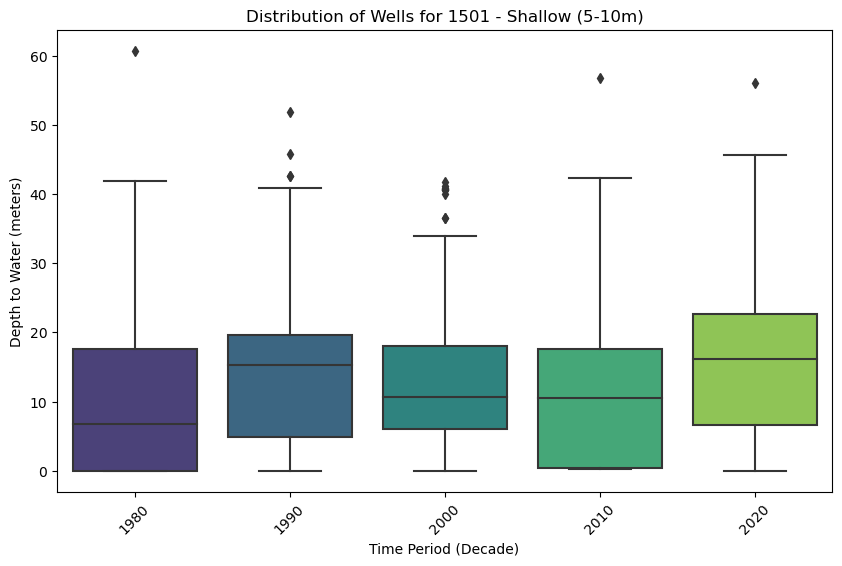

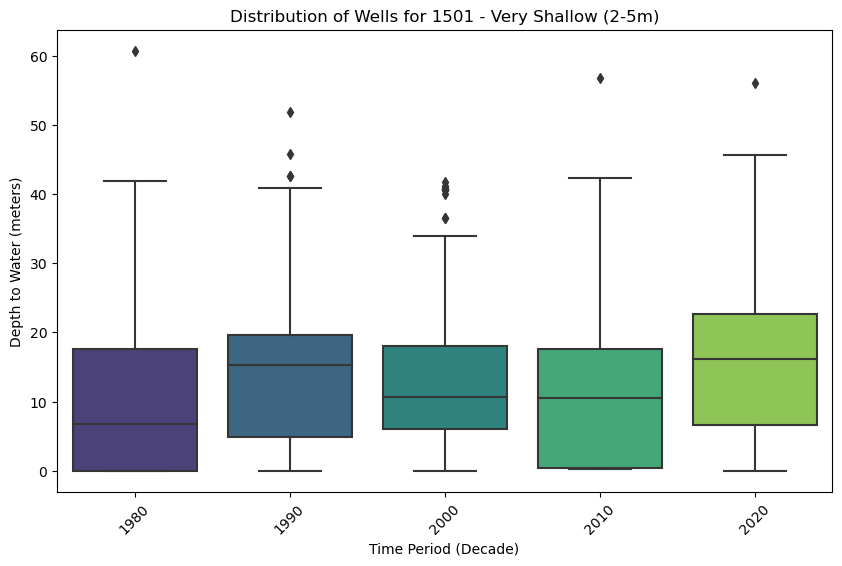

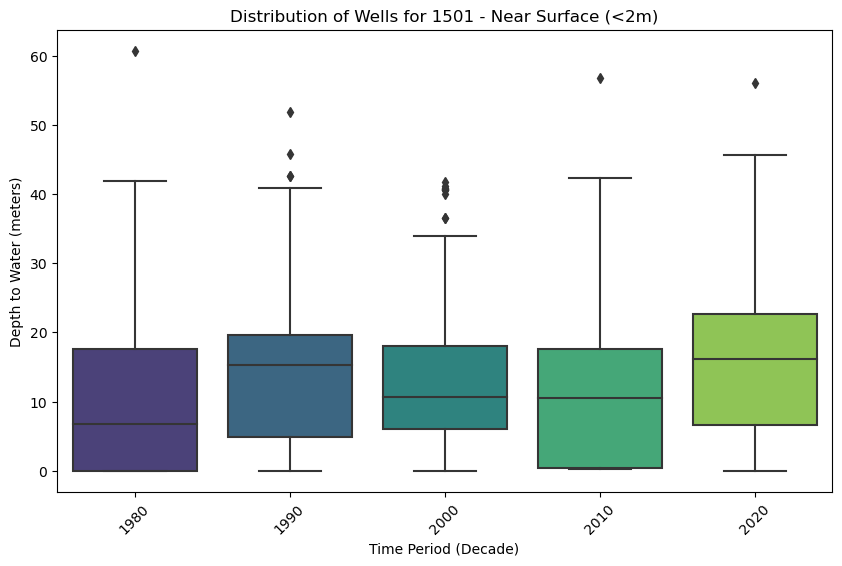

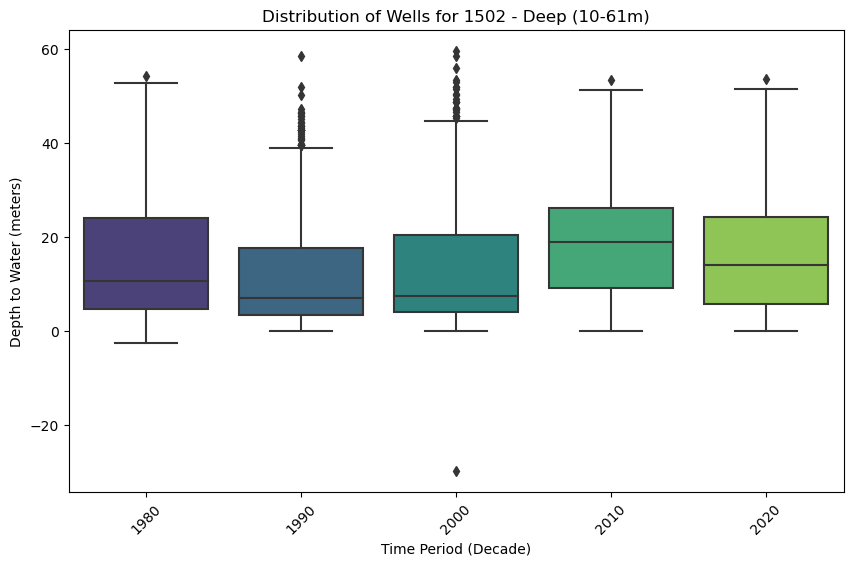

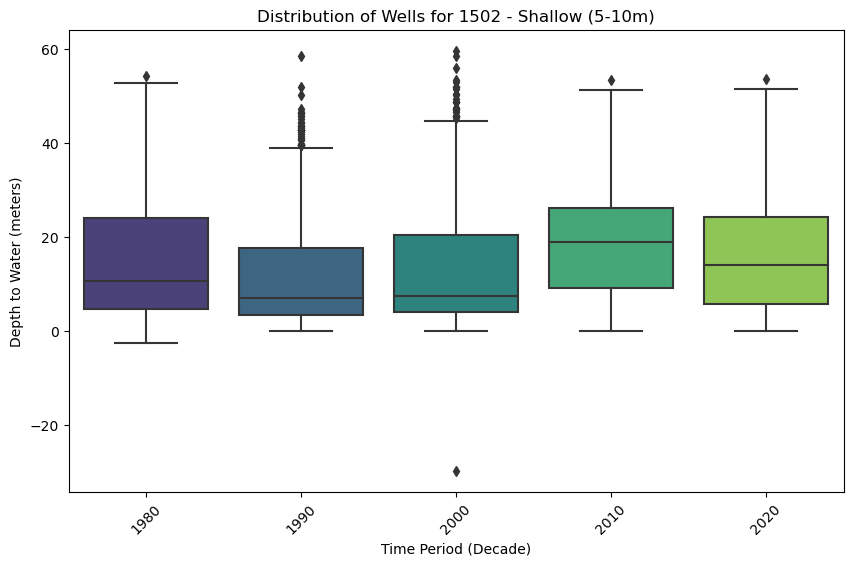

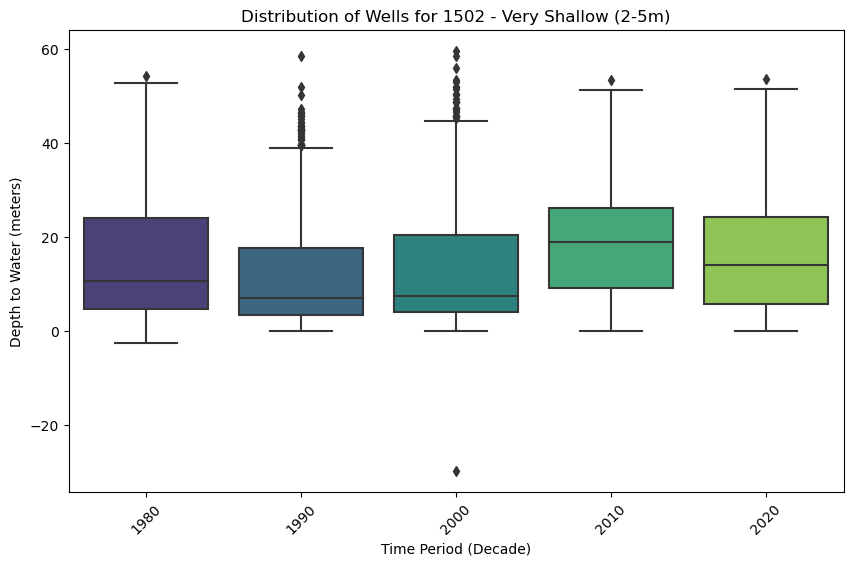

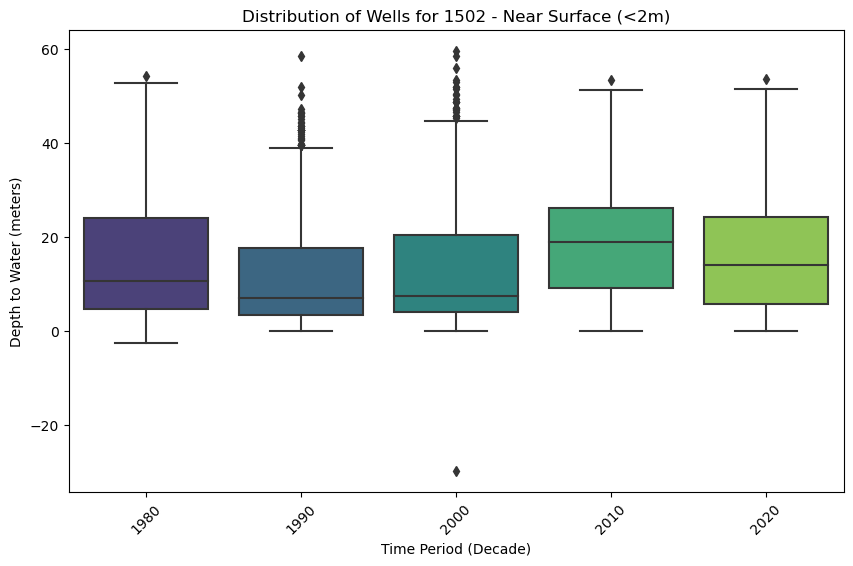

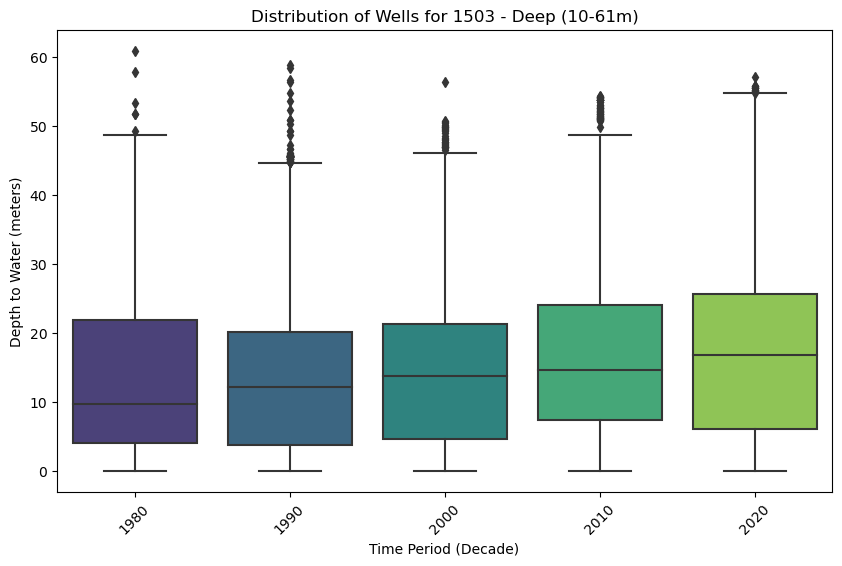

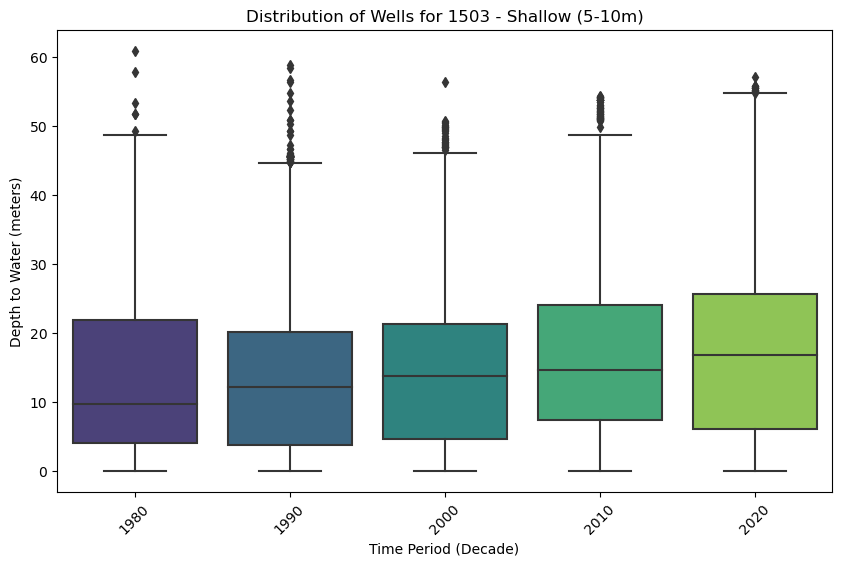

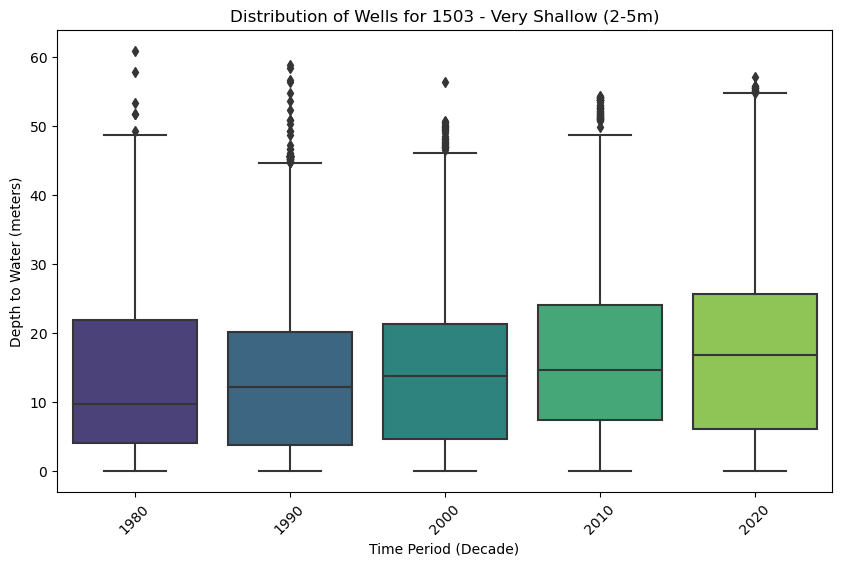

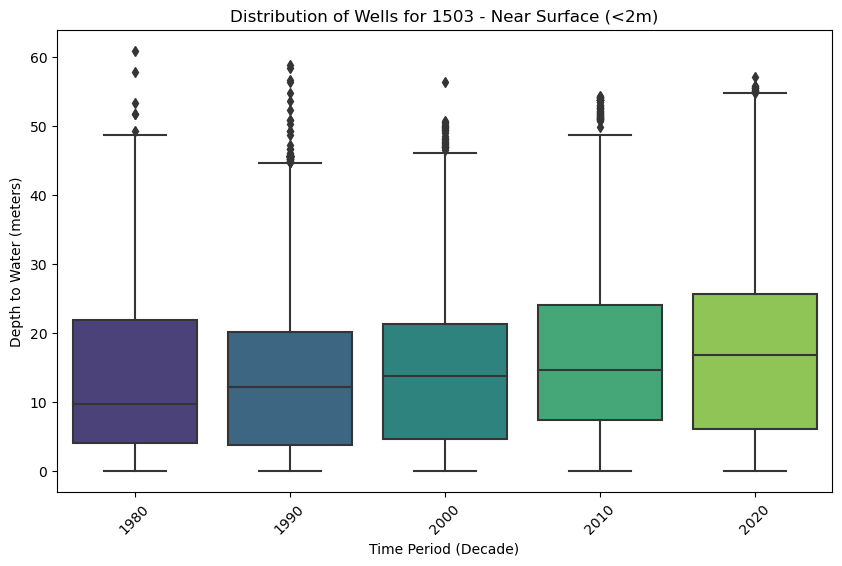

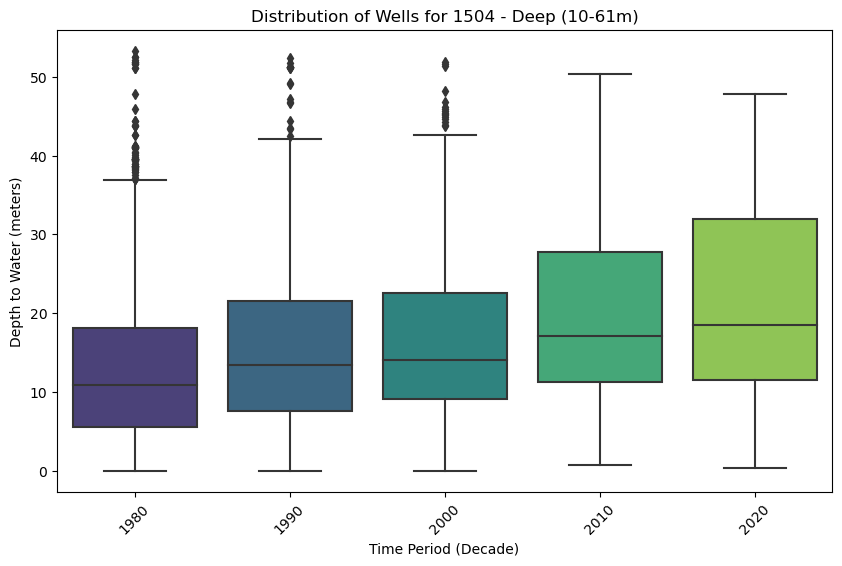

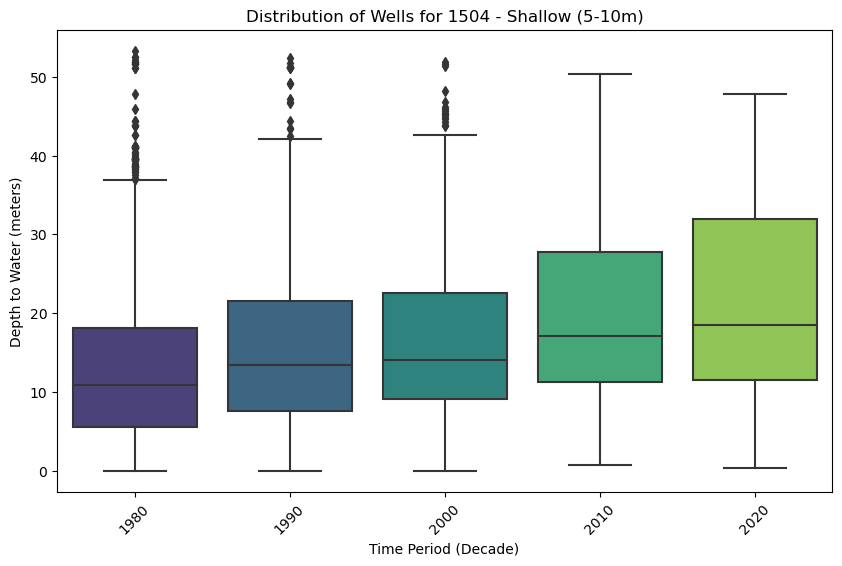

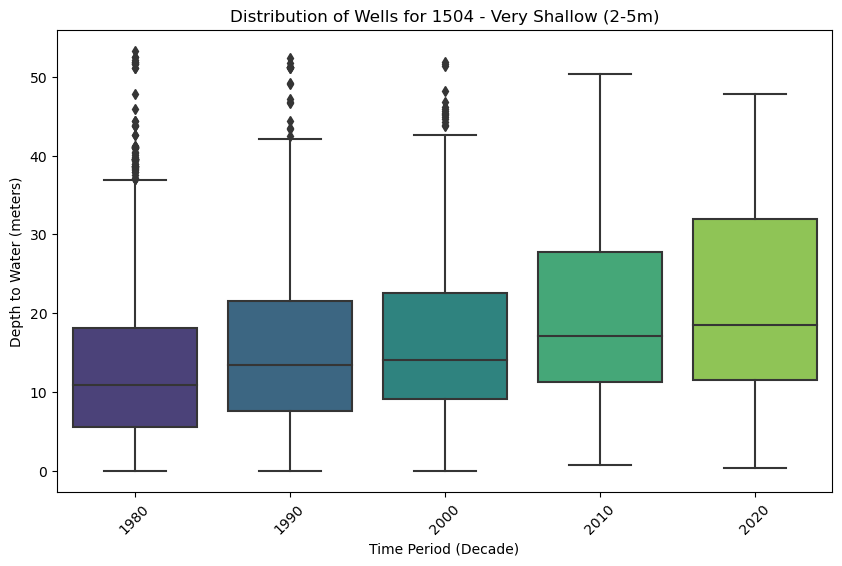

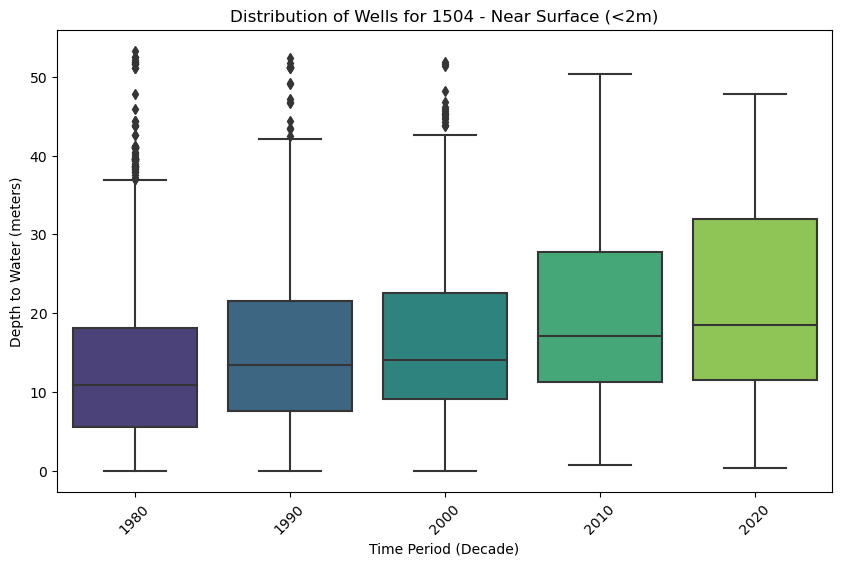

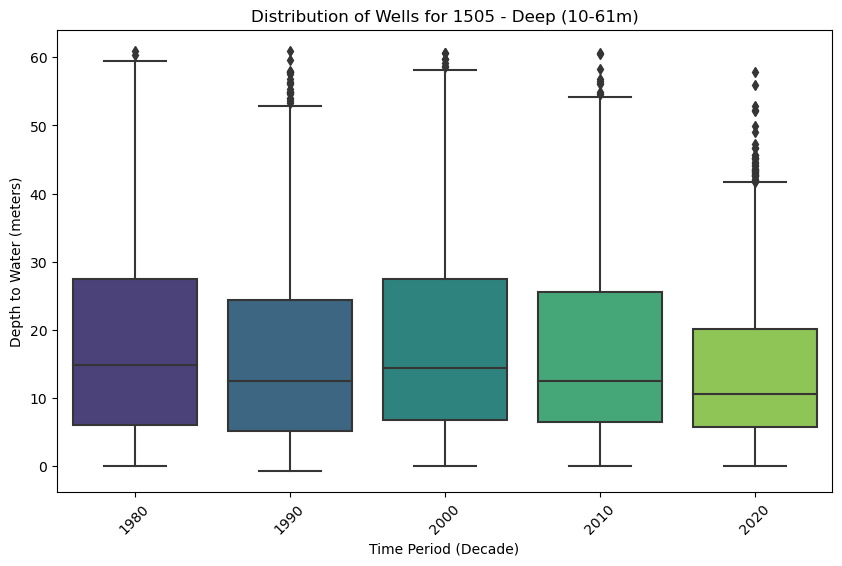

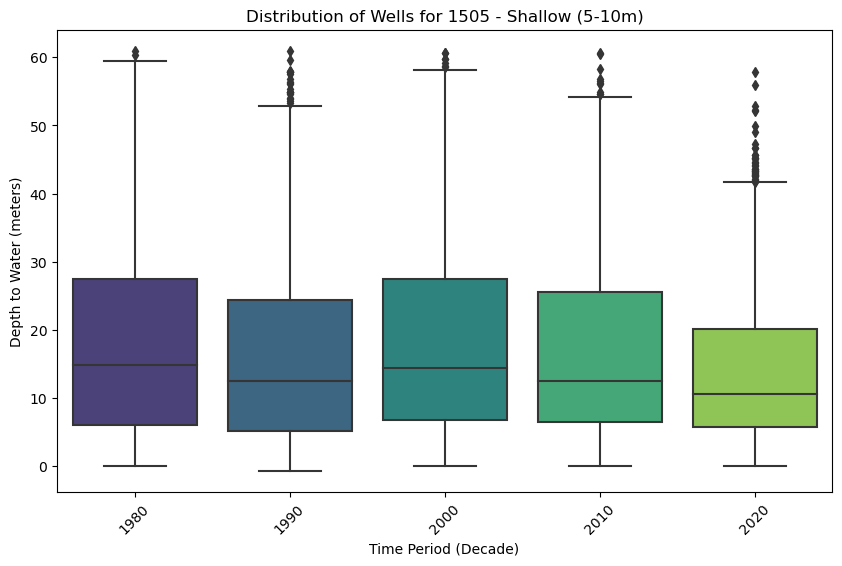

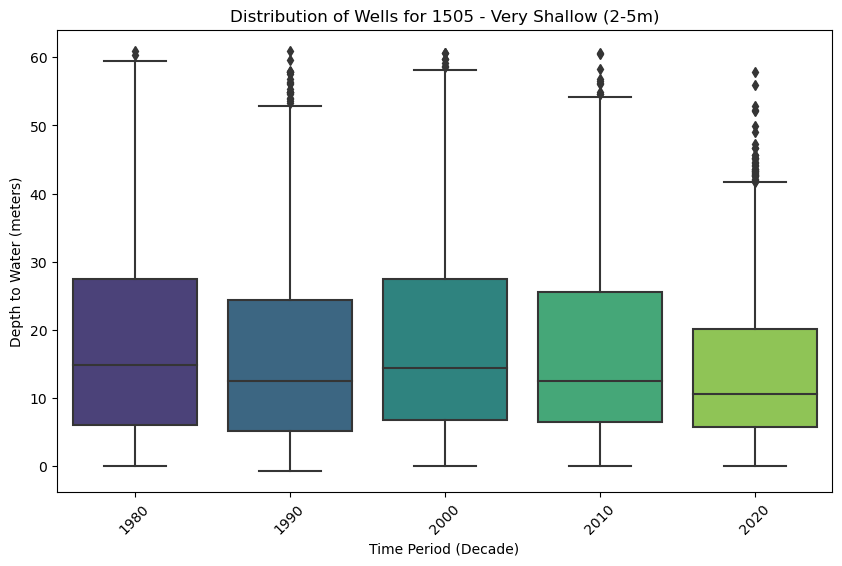

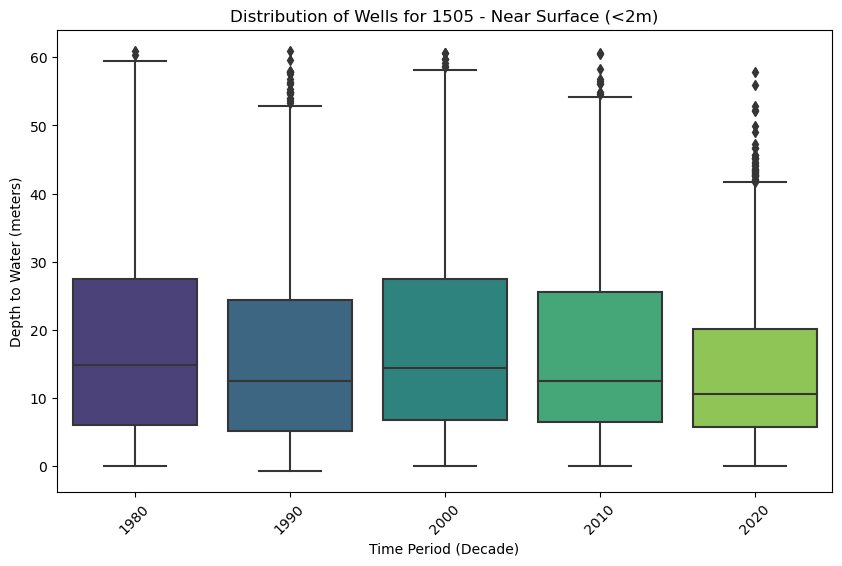

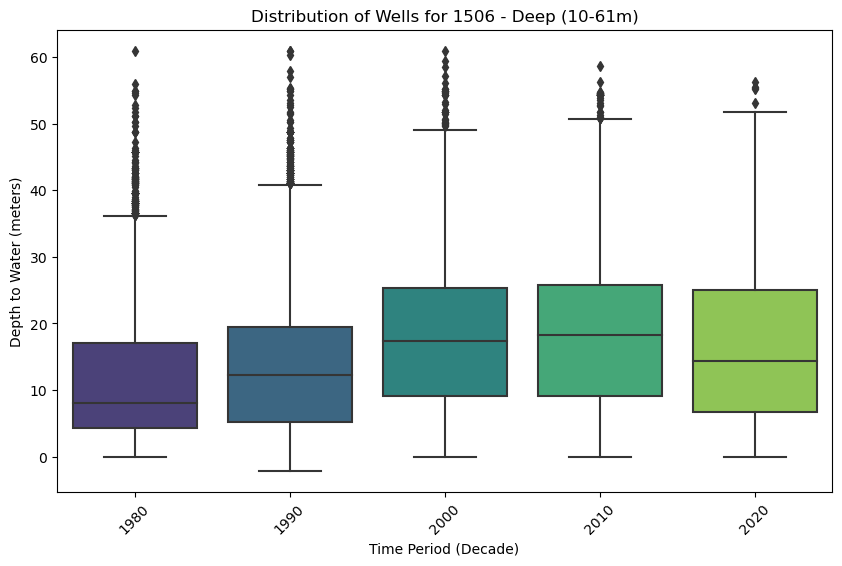

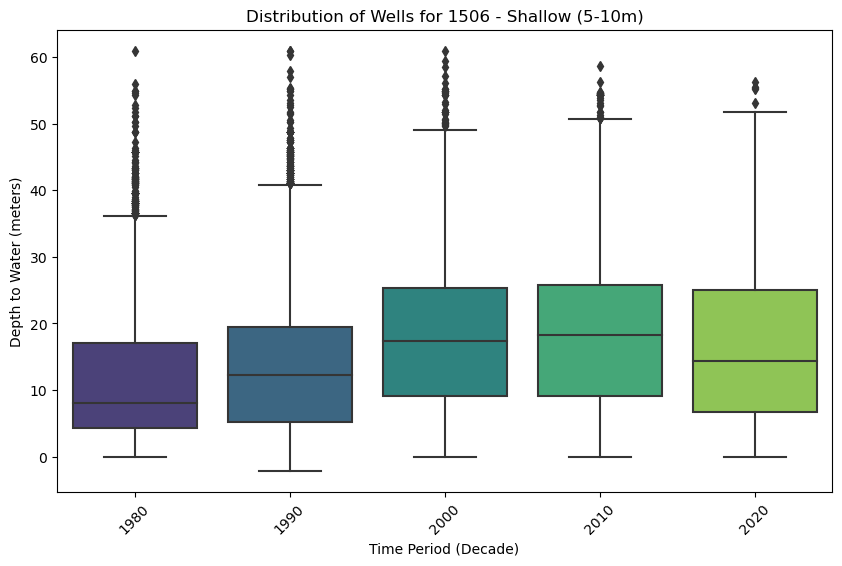

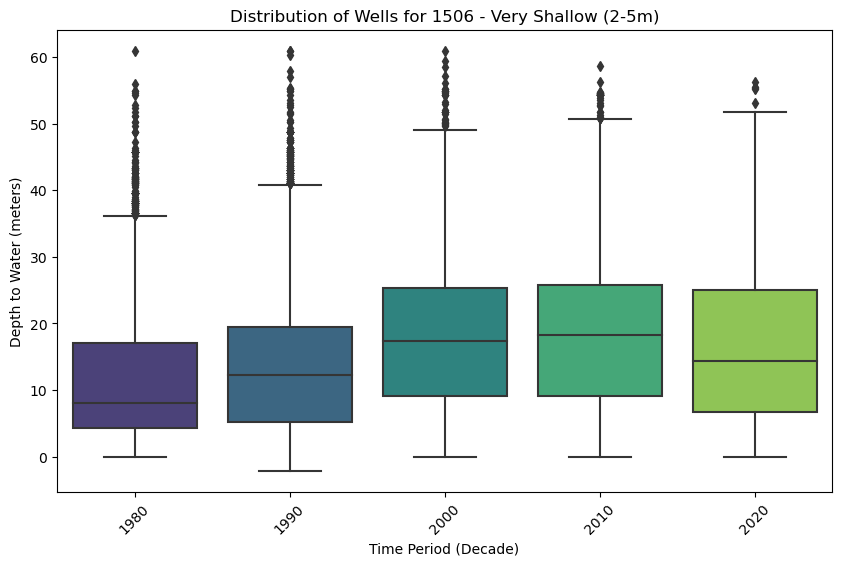

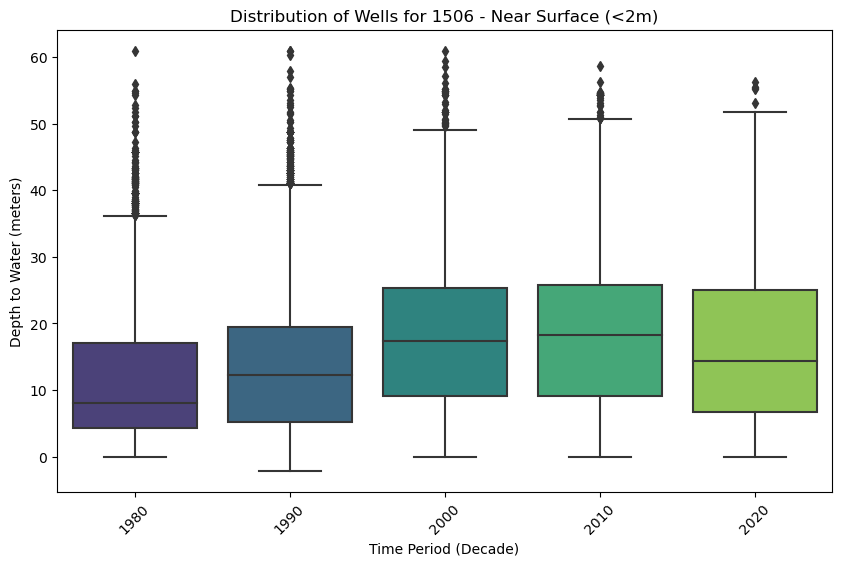

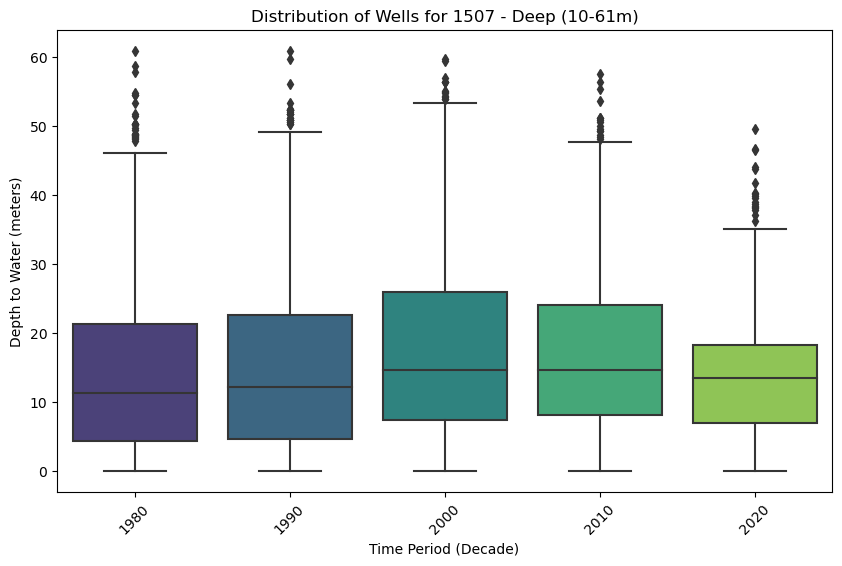

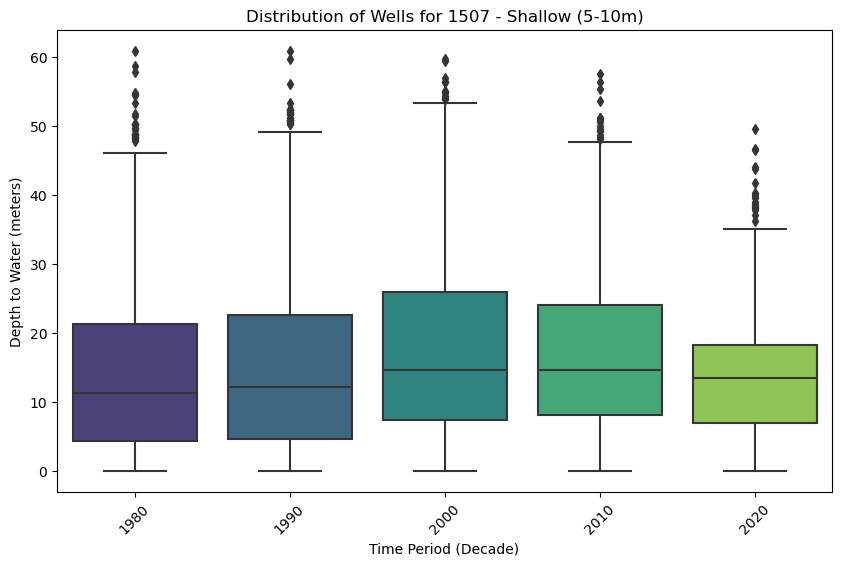

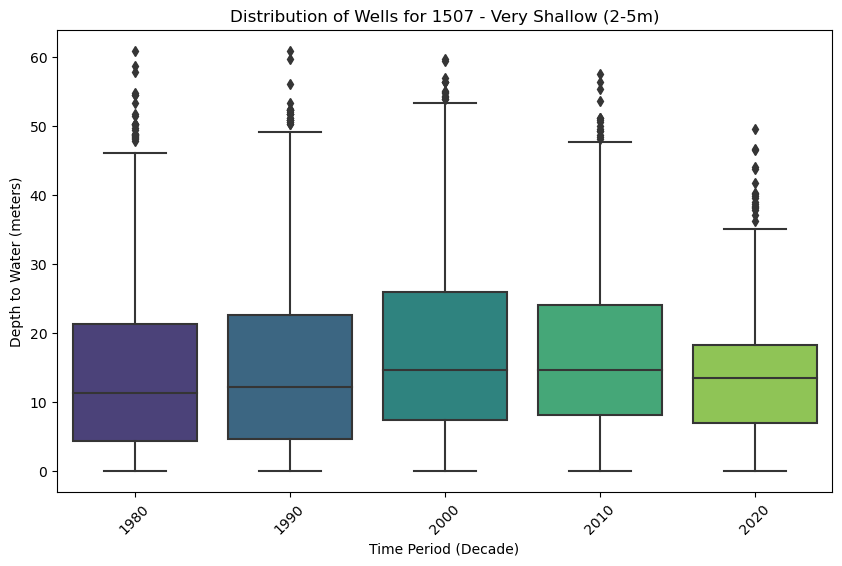

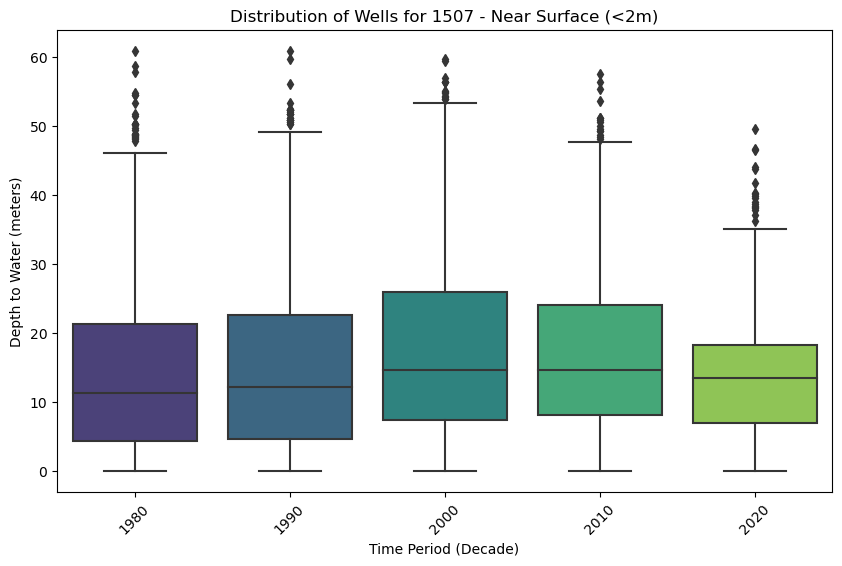

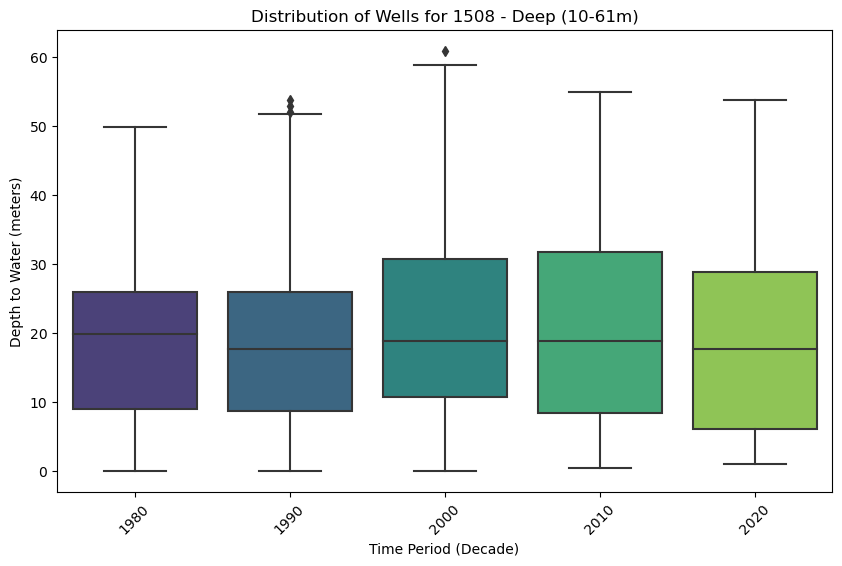

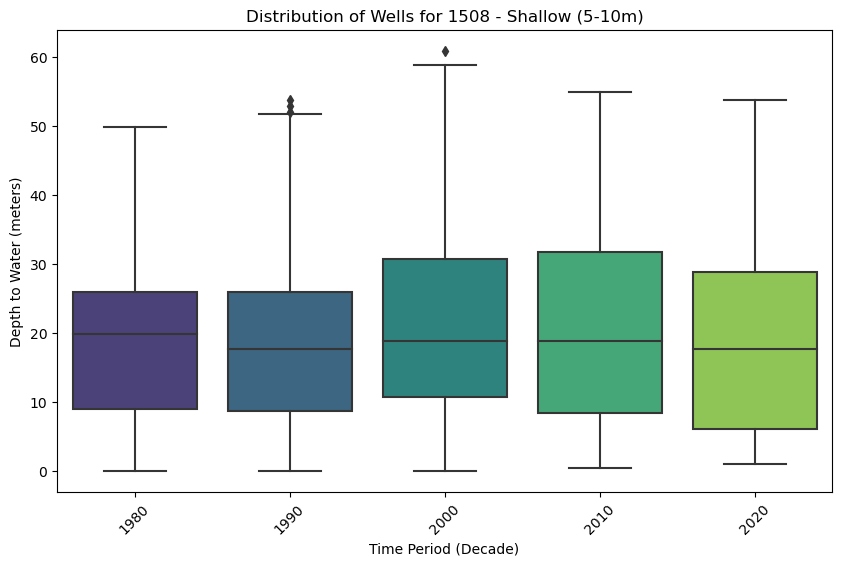

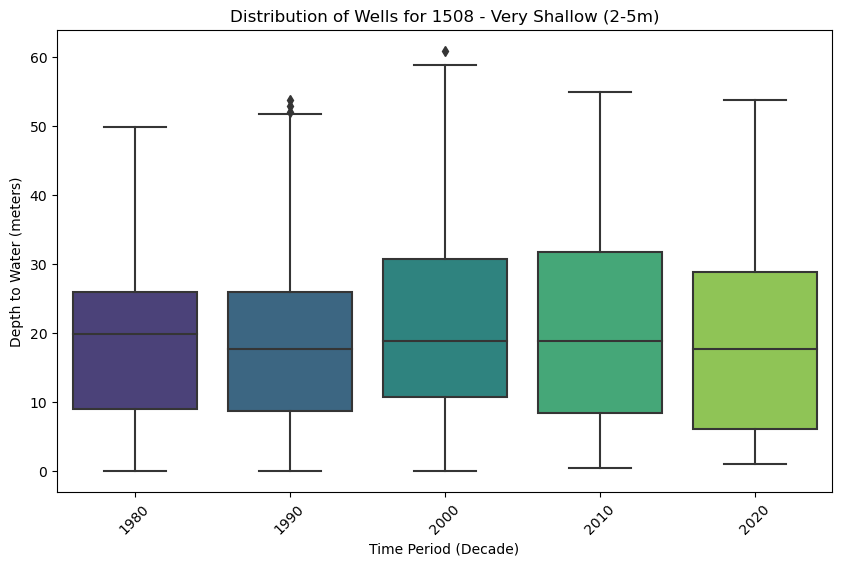

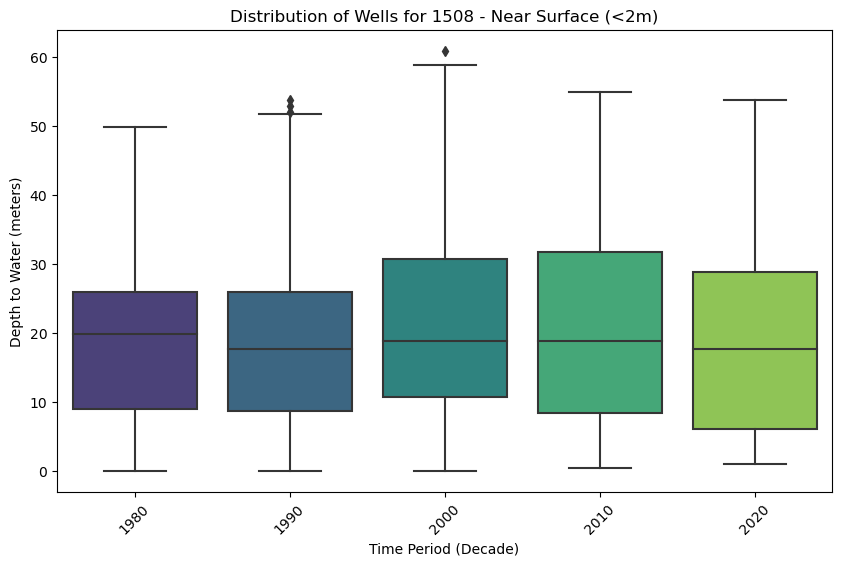

In [55]:
# Get unique DTW categories
dtw_categories = df_melted['DTW_Category'].unique()

# Loop through each DTW category and create a box plot
for bitch in listofhucs:
    subset_hucs = df_melted[df_melted[Naming_col+"_wb"]== bitch]
    for category in dtw_categories:
        plt.figure(figsize=(10, 6))
        
        # Subset data for the current category
        subset = subset_hucs[subset_hucs['DTW_Category'] == category]

        # Create the box plot
        sns.boxplot(data=subset_hucs, x='Decade', y='DTW_meters', palette='viridis')

        # Titles and labels
        plt.title(f'Distribution of Wells for {bitch} - {category}')
        plt.xlabel('Time Period (Decade)')
        plt.ylabel('Depth to Water (meters)')
        plt.xticks(rotation=45)

        # Show the plot
        plt.show()

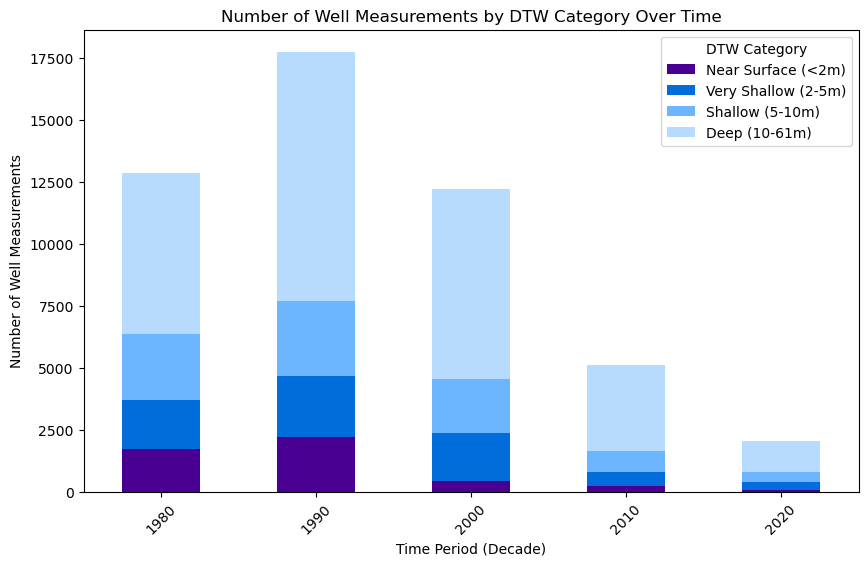

In [63]:
# Pivot the data to get each DTW category as a separate column for stacking
summary_pivot = summary_df.pivot(index='Decade', columns='DTW_Category', values='Well Count').fillna(0)

# Define the desired order for DTW categories
category_order = ['Near Surface (<2m)', 'Very Shallow (2-5m)', 'Shallow (5-10m)', 'Deep (10-61m)']

# Reorder the columns in summary_pivot
summary_pivot = summary_pivot[category_order]

# Define colors
colors = {
    'Near Surface (<2m)': cblind[5],
    'Very Shallow (2-5m)': cblind[6],
    'Shallow (5-10m)': cblind[8],
    'Deep (10-61m)': cblind[9]
}

# Plot stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))
summary_pivot.plot(kind='bar', stacked=True, color=[colors[c] for c in summary_pivot.columns], ax=ax)

# Labels and title
plt.xlabel('Time Period (Decade)')
plt.ylabel('Number of Well Measurements')
plt.title('Number of Well Measurements by DTW Category Over Time')
plt.legend(title='DTW Category')
plt.xticks(rotation=45)
# plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


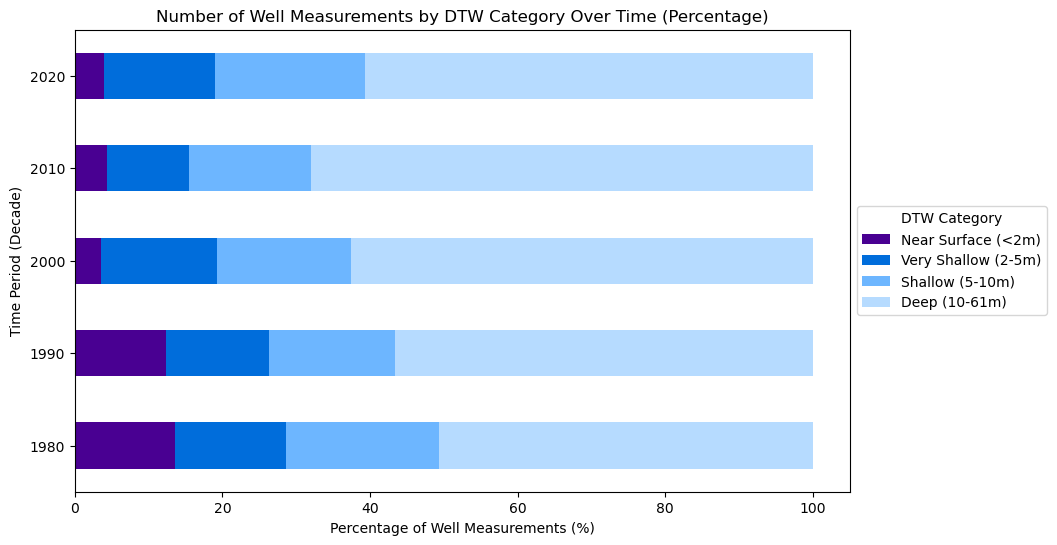

In [61]:
# Normalize data to get percentages
summary_pivot_percent = summary_pivot.div(summary_pivot.sum(axis=1), axis=0) * 100

# Plot stacked horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 6))
summary_pivot_percent.plot(
    kind='barh',  # Horizontal bar chart
    stacked=True, 
    color=[colors[c] for c in summary_pivot.columns], 
    ax=ax
)

# Labels and title
plt.xlabel('Percentage of Well Measurements (%)')
plt.ylabel('Time Period (Decade)')
plt.title('Number of Well Measurements by DTW Category Over Time (Percentage)')
plt.legend(title='DTW Category', loc='center left', bbox_to_anchor=(1, 0.5))  # Move legend outside for clarity
plt.xticks(rotation=0)  # Keep x-axis labels horizontal

plt.show()


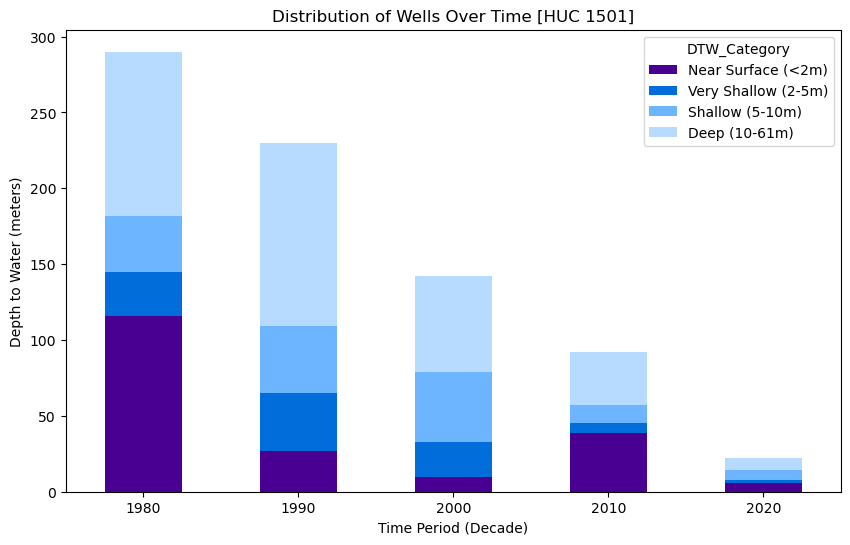

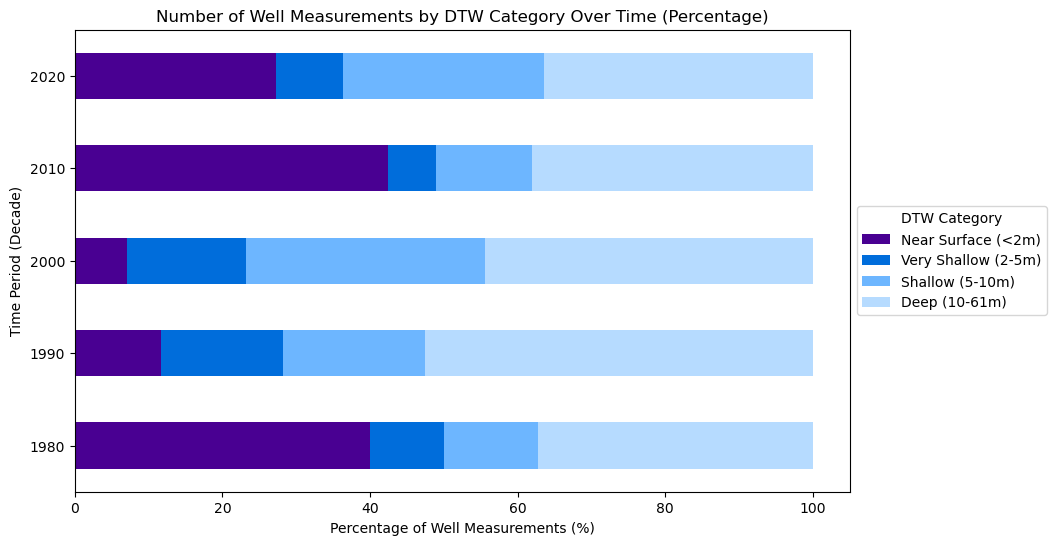

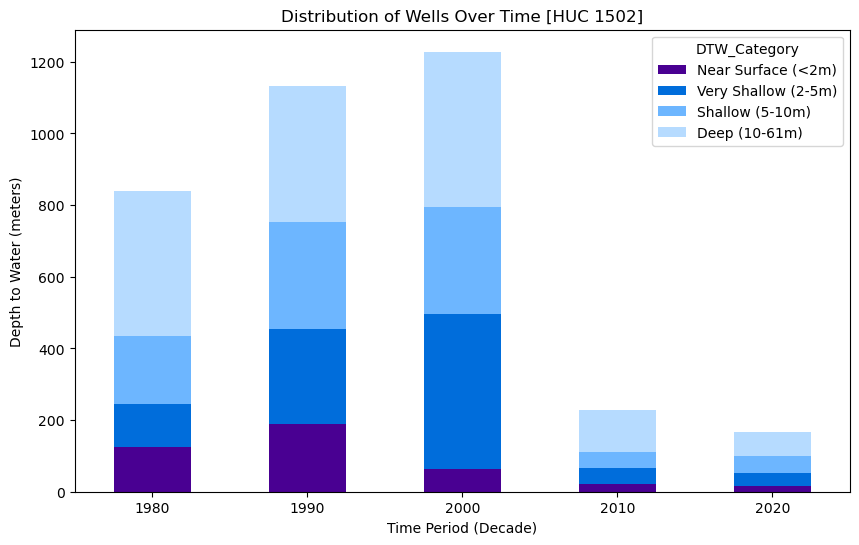

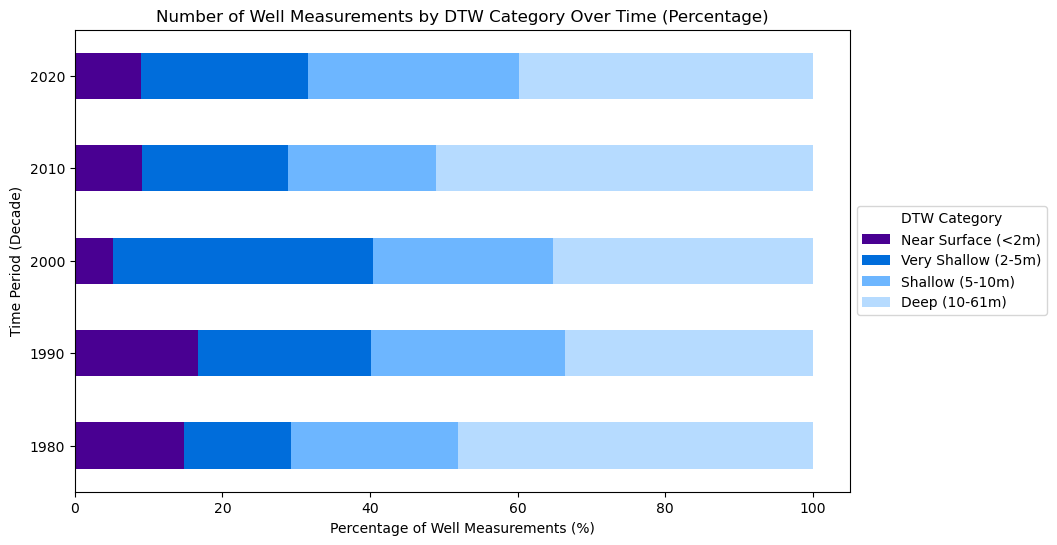

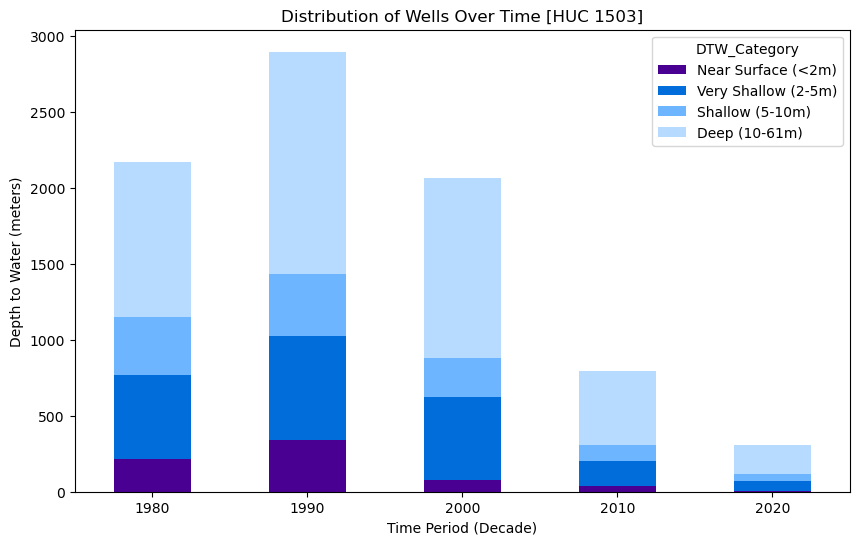

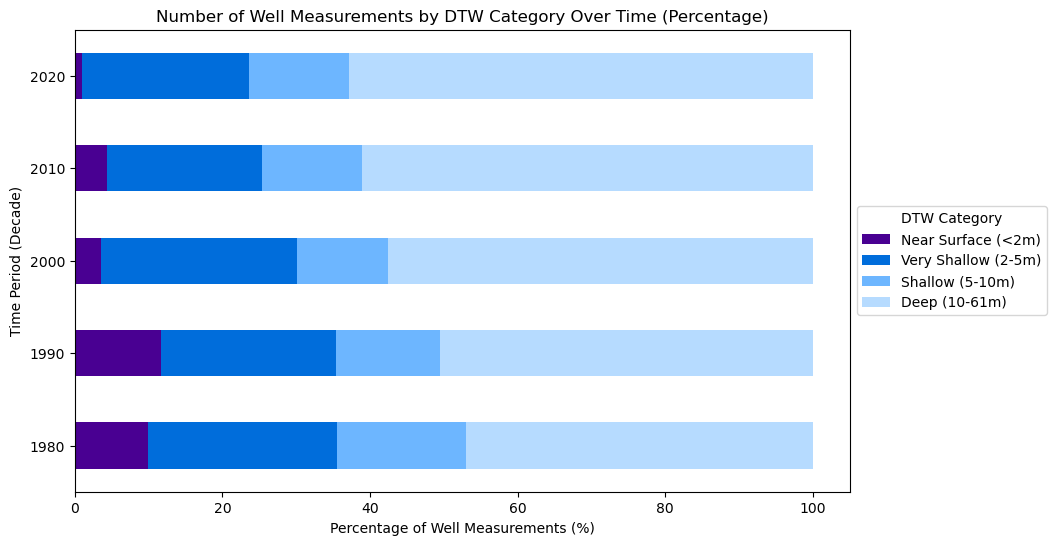

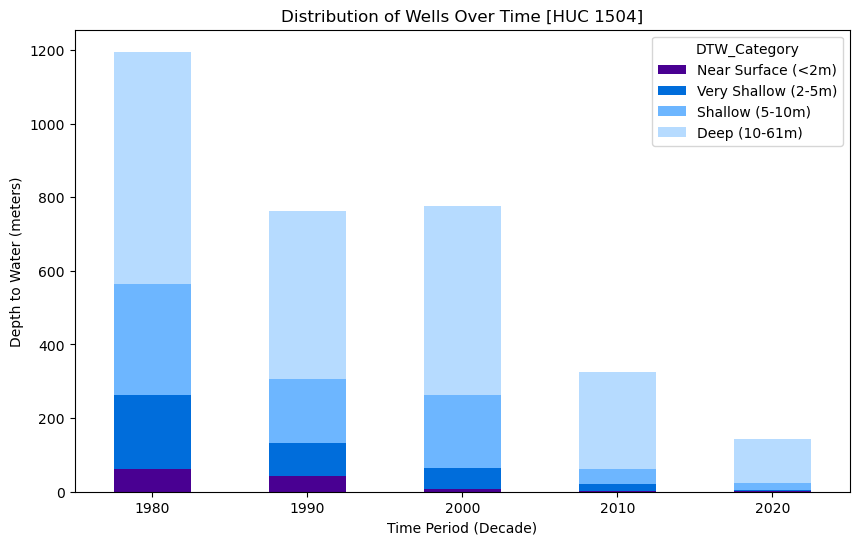

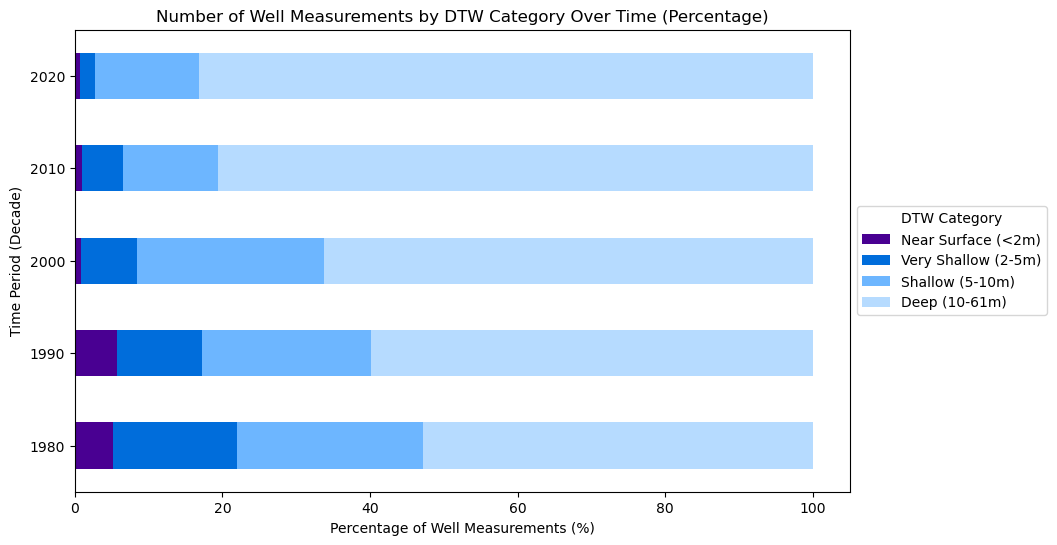

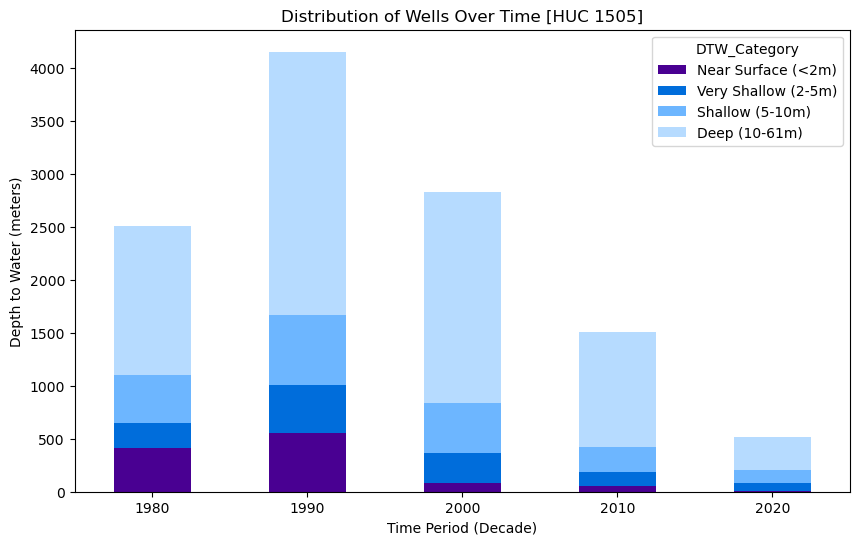

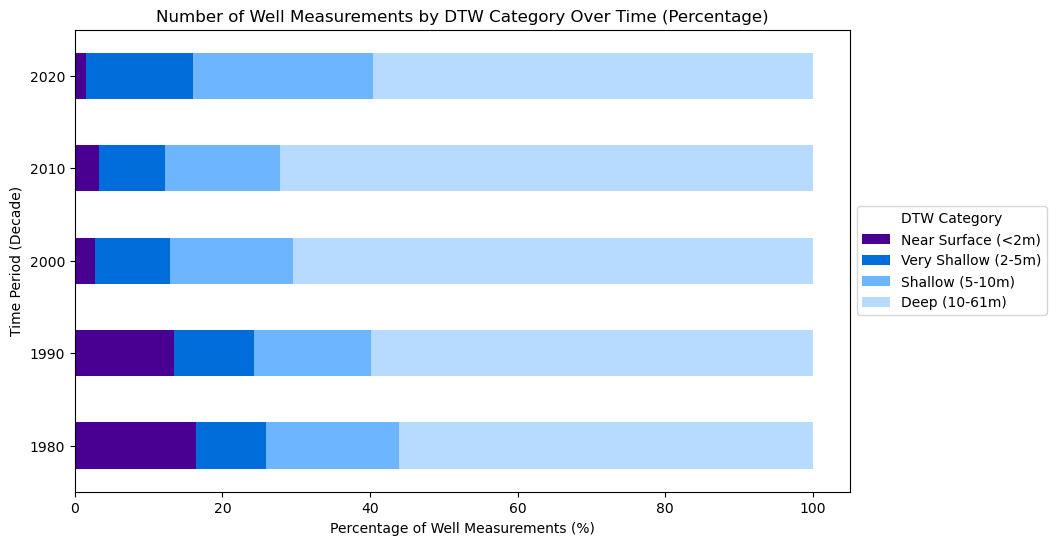

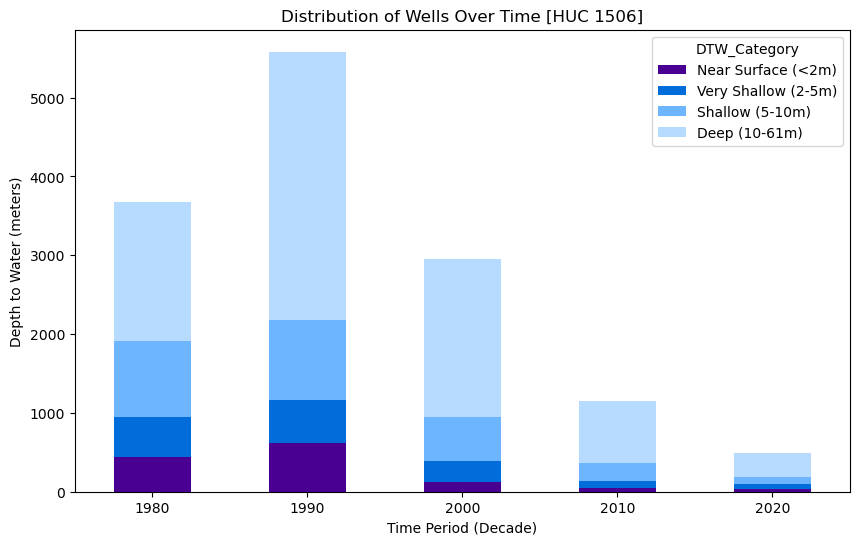

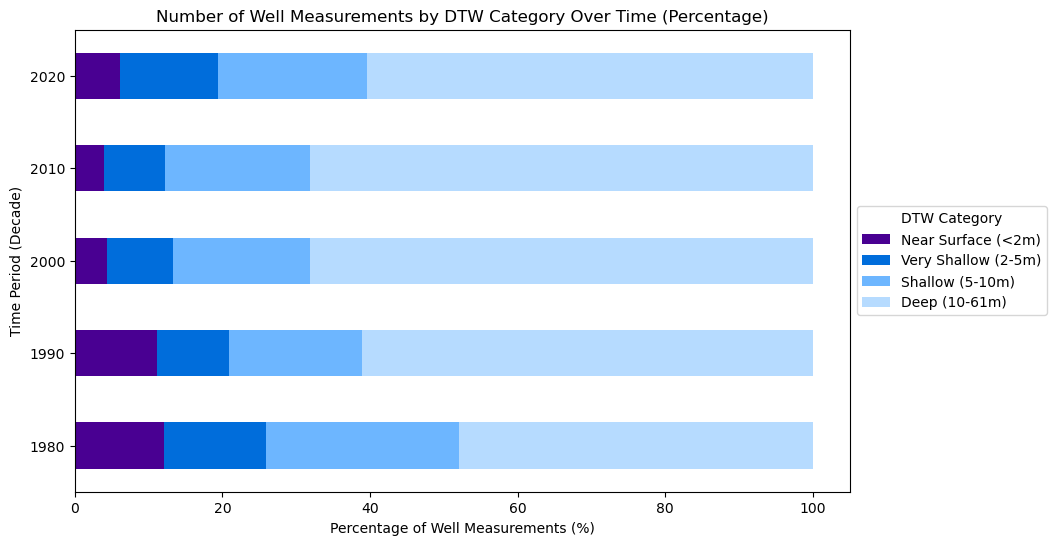

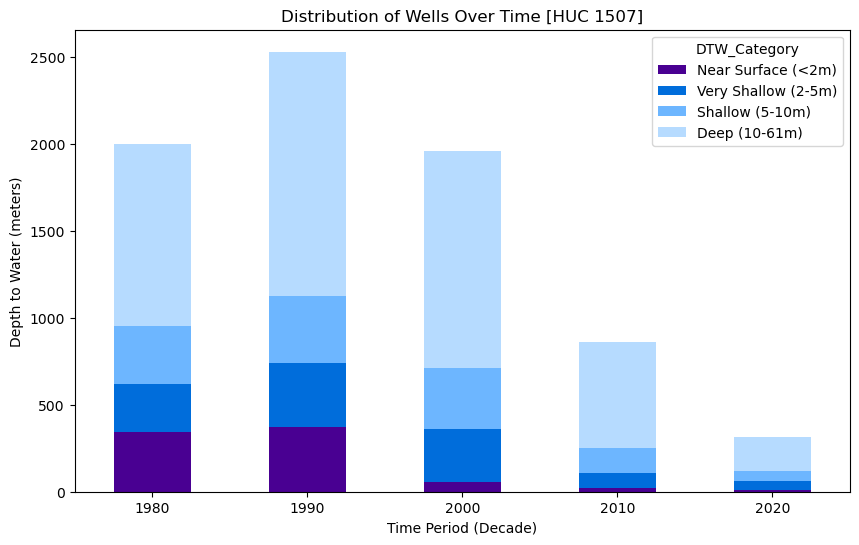

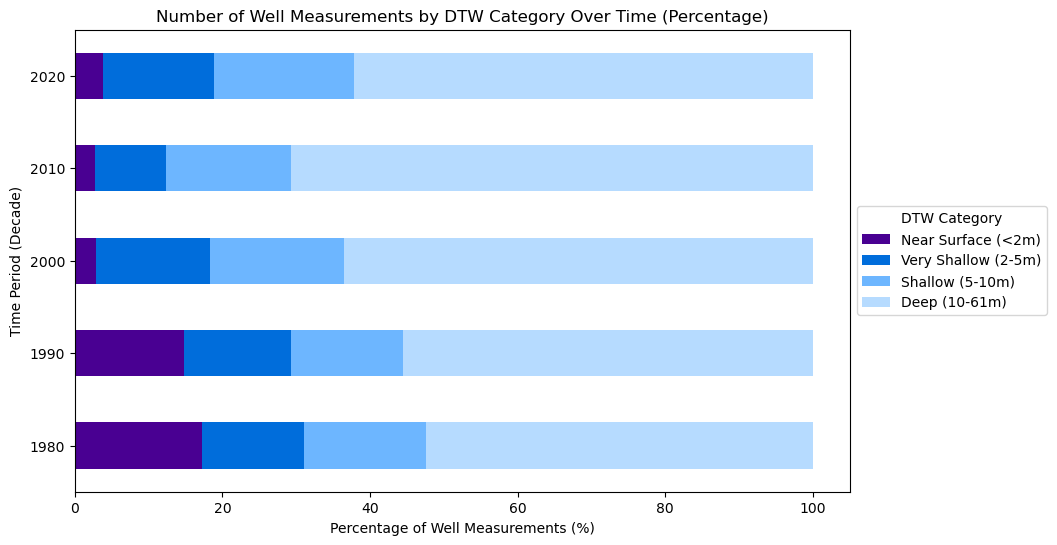

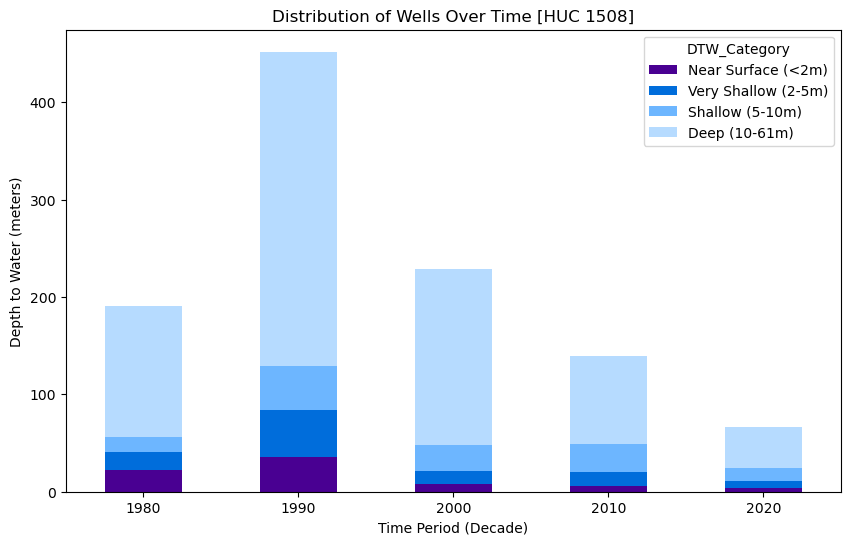

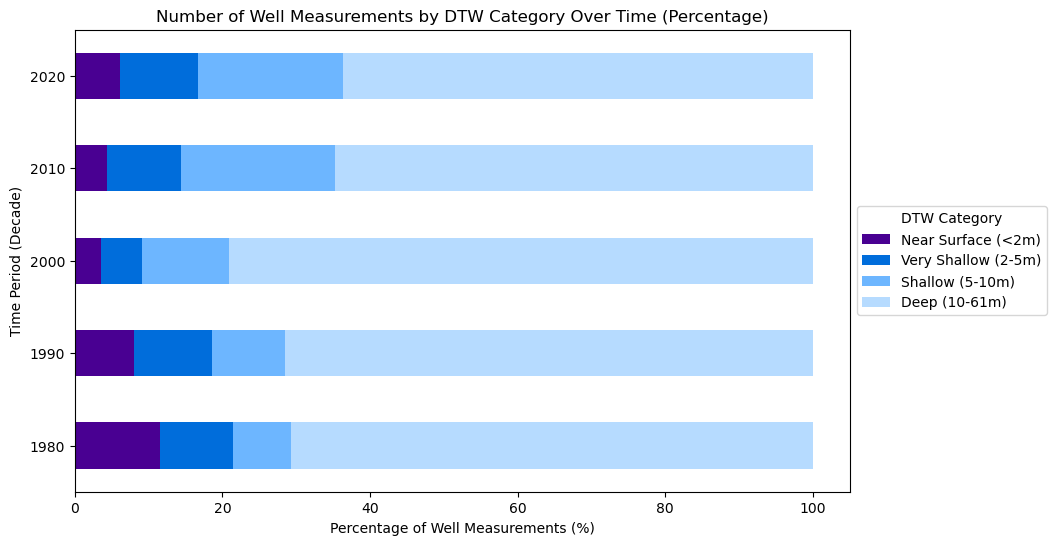

In [72]:
listofhucs = df_melted[Naming_col+"_wb"].unique().tolist()
num_hucs = len(listofhucs)

# Determine grid size
cols = math.ceil(math.sqrt(num_hucs))  # Try to make a roughly square grid
rows = math.ceil(num_hucs / cols)

# fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 6), constrained_layout=True)

# Flatten axes if there's more than one row
if rows > 1 or cols > 1:
    axes = axes.flatten()
else:
    axes = [axes]  # Ensure it's iterable

for i, bitch in enumerate(listofhucs):
    subset = df_melted[df_melted[Naming_col+"_wb"] == bitch]
    summary_df_huc = subset.groupby(['Decade', 'DTW_Category'])['Combo_ID'].nunique().reset_index()
    summary_df_huc.rename(columns={'Combo_ID': 'Well Count'}, inplace=True)
    summary_pivot = summary_df_huc.pivot(index='Decade', columns='DTW_Category', values='Well Count').fillna(0)
    summary_pivot = summary_pivot[category_order]
    fig, ax = plt.subplots(figsize=(10, 6))
    summary_pivot.plot(kind='bar', stacked=True, color=[colors[c] for c in summary_pivot.columns], ax=ax)
    ax.set_title(f'Distribution of Wells Over Time [HUC {bitch}]')
    ax.set_xlabel('Time Period (Decade)')
    ax.set_ylabel('Number of Well Measurements')
    ax.tick_params(axis='x', rotation=0)
    # axes[i].set_ylim(65, -5)
    summary_pivot_percent = summary_pivot.div(summary_pivot.sum(axis=1), axis=0) * 100

    # Plot stacked horizontal bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    summary_pivot_percent.plot(
        kind='barh',  # Horizontal bar chart
        stacked=True, 
        color=[colors[c] for c in summary_pivot.columns], 
        ax=ax
    )

    # Labels and title
    plt.xlabel('Percentage of Well Measurements (%)')
    plt.ylabel('Time Period (Decade)')
    plt.title('Number of Well Measurements by DTW Category Over Time (Percentage)')
    plt.legend(title='DTW Category', loc='center left', bbox_to_anchor=(1, 0.5))  # Move legend outside for clarity
    plt.xticks(rotation=0)  # Keep x-axis labels horizontal

    plt.show()


In [68]:
summary_pivot

DTW_Category,Deep (10-61m),Near Surface (<2m),Shallow (5-10m),Very Shallow (2-5m)
Decade,,,,
1980,135,22,15,19
1990,323,36,45,48
2000,181,8,27,13
2010,90,6,29,14
2020,42,4,13,7


This is where we do the above but to river lengths of different distances

In [75]:
# Would like to turn a bunch of code into a for-loop

distances = [100, 
            #  500, 
            #  1000, 
            #  1500, 
            #  2000
             ]

# Create some dictionaries
sgdb_distances = {}  # Storing static databases
combo_distances = {} # Storing combo databases
melted_distances = {} # Melted dataframes
summary_distances = {} # Well counts and such

for i in distances:
    # mdb = masterdb.set_crs(epsg=26912)
    mdb = static_geo.copy()
    b = shapefile.copy()
    b = b.to_crs(3857)
    b['geometry'] = b.geometry.buffer(i)
    b = b.to_crs(epsg=26912)
    print(f"Buffering {i}m complete.")
    sgdb_distances[f"sgdb_{i}m"] = gp.sjoin(mdb, b, how="inner", 
                                        # , op='intersects' 
                                          predicate="intersects"
                                          )

    print(f"{filename_mdb_nd} and {i}m shapefile join complete.")
    # sgdb_distances[f"sgdb_{i}m"].plot()
    sgdb_i = sgdb_distances[f"sgdb_{i}m"]

    # Export the buffered shapefile for creating maps
    # buffered.to_file(f'{outputpath}/{StudyArea}bufferedflowlines_{distance}m.shp')
    
    reg_list = sgdb_i[['Combo_ID', Naming_col,'WELL_DEPTH','WELL_TYPE_','reachcode'
                # ,'fcode','hydroseq'
                  ]]

    # Converting Combo_ID to int
    reg_list['Combo_ID'] = reg_list['Combo_ID'].astype(np.int64, errors = 'raise')

    # Merging the Timeseries and the shapefile static database
    combo_distances[f"sgdb_{i}m"] = annual_db2.merge(reg_list, how="inner")
    combo_i = combo_distances[f"sgdb_{i}m"]
    print(f"Creating the combo database for {i}m complete.")

    # set index to Combo_ID
    combo_i.set_index('Combo_ID', inplace=True)
    combo_i = combo_i[(combo_i['WELL_DEPTH']<=200)&(combo_i['WELL_DEPTH']>0)]
    combo_i = combo_i.reset_index()  # Moves well_ID from index to a column (if needed)
    print(f"Only wells drilled between 0 and 200ft (61m) are filtered.")
    # Makes sure wells aren't being counted twice
    combo_i = combo_i.drop_duplicates(subset=["Combo_ID", Naming_col])
    combo_i = combo_i.set_index("Combo_ID")
    print(f"Duplicates dropped.")

    # Gets it ready for stats
    combo_i = combo_i.drop(['WELL_DEPTH','WELL_TYPE_'
                            # ,'nan'
                            ,'reachcode'
                            # ,'fcode','hydroseq'
                            ],axis=1)

    # Makes sure we don't get any deep readings.  Might not include this in the analysis
    df = combo_i
    # Step 1: Filter columns for readings after 1980
    date_cols = [col for col in df.columns if col not in ['Combo_ID', Naming_col] and col >= '1980-01']
    # Step 2: Find wells with any reading > 200 ft in these columns
    mask = (df[date_cols] > 200).any(axis=1)
    # Step 3: Drop wells that meet this condition
    df_filtered = df[~mask]
    # Now df_filtered contains only wells that never exceeded 200 ft after 1980
    combo_i = df_filtered.copy()
    print("Only wells without anomalous readings are selected.")

    combo_i = combo_i.reset_index()
    date_cols = [col for col in combo_i.columns if col not in ['Combo_ID', Naming_col] and col >= '1980-01']  # Keep only years >= 1980
    combo_i = combo_i[['Combo_ID', Naming_col] + date_cols]
    print("Timeframe narrowed (1980-01 to present).")


combo_i

Buffering 100m complete.
Master_ADWR_database_noduplicates.shp and 100m shapefile join complete.


C:\Users\det19\AppData\Local\Temp\ipykernel_8152\1428600710.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_list['Combo_ID'] = reg_list['Combo_ID'].astype(np.int64, errors = 'raise')


Creating the combo database for 100m complete.
Only wells drilled between 0 and 200ft (61m) are filtered.
Duplicates dropped.
Only wells without anomalous readings are selected.
Timeframe narrowed (1980-01 to present).


,Combo_ID,huc4,1980-01,1980-02,1980-03,1980-04,1980-05,1980-06,1980-07,1980-08,...,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12,2024-01,2024-02,2024-03
0,84614,1504,NaN,NaN,NaN,NaN,NaN,NaN,12.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,84717,1506,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,84828,1506,18.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,84969,1505,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,84970,1506,NaN,NaN,NaN,NaN,NaN,NaN,18.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7716,363620113565501,1501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,7.70,NaN,NaN,6.70,NaN,8.30,NaN,NaN,NaN
7717,363822111515101,1501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7718,364327113040601,1501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7719,364328113040801,1501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [74]:
combo_i

,1853-12,1856-01,1857-12,1860-01,1864-01,1868-01,1870-01,1871-01,1872-01,1873-01,...,2023-10,2023-11,2023-12,2024-01,2024-02,2024-03,huc4,WELL_DEPTH,WELL_TYPE_,reachcode
Combo_ID,,,,,,,,,,,,,,,,,,,,,
84614,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1504,80.00,NON-EXEMPT,15040002000055
84717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1506,105.00,EXEMPT,15060203000271
84828,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1506,93.00,EXEMPT,15060202000561
84969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1505,150.00,EXEMPT,15050202000096
84970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1506,80.00,EXEMPT,15060105000709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363620113565501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.70,NaN,8.30,NaN,NaN,NaN,1501,153.00,NaN,15010006000588
363822111515101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1501,50.00,NaN,15010001012833
364327113040601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1501,25.00,NaN,15010009001442
